# Paddle动态图自定义剪裁策略教程

## 1. 概述

该教程介绍如果在PaddleSlim提供的接口基础上快速自定义`Filters`剪裁策略。
在PaddleSlim中，所有剪裁`Filters`的`Pruner`继承自基类`FilterPruner`。`FilterPruner`中自定义了一系列通用方法，用户只需要重载实现`FilterPruner`的`cal_mask`接口，`cal_mask`接口定义如下：

In [1]:
def cal_mask(self, var_name, pruned_ratio, group):
    raise NotImplemented()

`cal_mask`接口接受的参数说明如下：
- **var_name:** 要剪裁的目标变量，一般为卷积层的权重参数的名称。在Paddle中，卷积层的权重参数格式为`[output_channel, input_channel, kernel_size, kernel_size]`，其中，`output_channel`为当前卷积层的输出通道数，`input_channel`为当前卷积层的输入通道数，`kernel_size`为卷积核大小。
- **pruned_ratio:** 对名称为`var_name`的变量的剪裁率。
- **group:** 与待裁目标变量相关的所有变量的信息。

### 1.1 Group概念介绍 

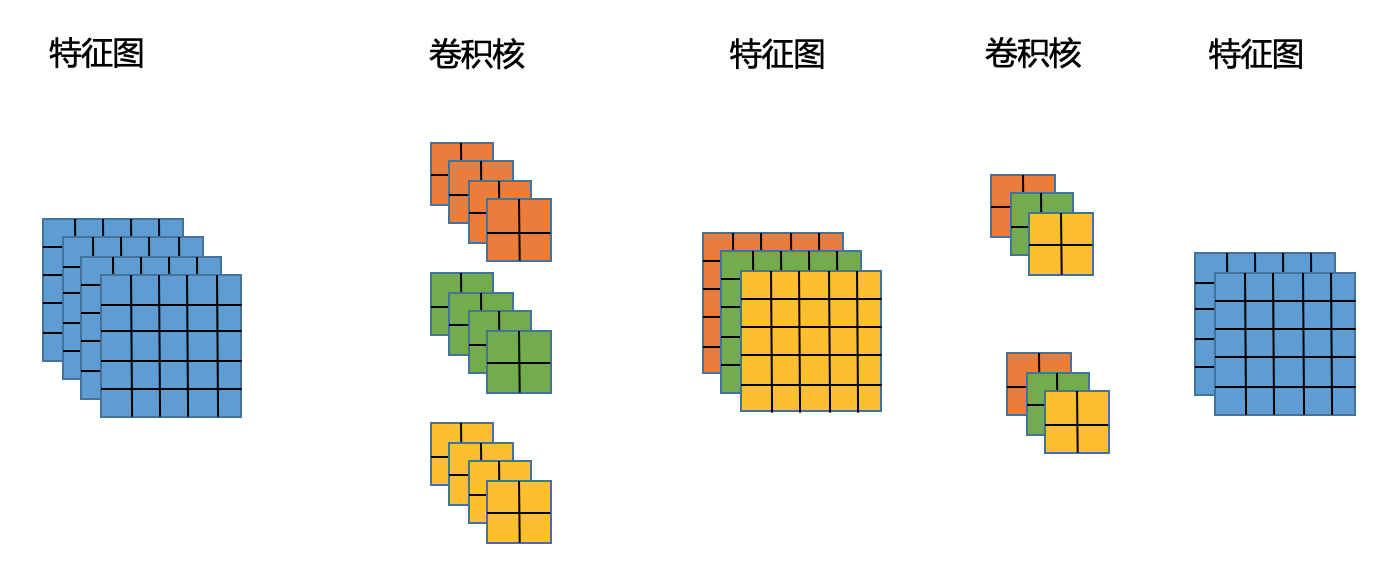
<center>图1-1 卷积层关联关系示意图</center>

如图1-1所示，在给定模型中有两个卷积层，第一个卷积层有3个`filters`，第二个卷积层有2个`filters`。如果删除第一个卷积绿色的`filter`，第一个卷积的输出特征图的通道数也会减1，同时需要删掉第二个卷积层绿色的`kernels`。如上所述的两个卷积共同组成一个group，表示如下：

```
group = {
            "conv_1.weight":{
                "pruned_dims": [0],
                "layer": conv_layer_1,
                "var": var_instance_1,
                "value": var_value_1,
            },
            "conv_2.weight":{
                "pruned_dims": [1],
                "layer": conv_layer_2,
                "var": var_instance_2,
                "value": var_value_2,
            }
        }
```

在上述表示`group`的数据结构示例中，`conv_1.weight`为第一个卷积权重参数的名称，其对应的value也是一个dict实例，存放了当前参数的一些信息，包括：
- **pruned_dims:** 类型为`list<int>`，表示当前参数在哪些维度上被裁。
- **layer:** 类型为[paddle.dygraph.Layer](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/dygraph_cn/Layer_cn.html#layer), 表示当前参数所在`Layer`。
- **var:** 类型为[paddle.Variable](https://www.paddlepaddle.org.cn/documentation/docs/zh/api_cn/fluid_cn/Variable_cn.html#variable), 表示当前参数对应的实例。
- **value:** 类型为numpy.array类型，待裁参数所存的具体数值，方便开发者使用。

图1-2为更复杂的情况，其中，`Add`操作的所有输入的通道数需要保持一致，`Concat`操作的输出通道数的调整可能会影响到所有输入的通道数，因此`group`中可能包含多个卷积的参数或变量，可以是：卷积权重、卷积bias、`batch norm`相关参数等。

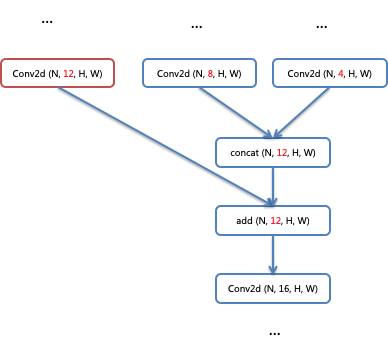
<center>图1-2</center>

## 2. 定义模型

In [2]:
import paddle
from paddle.vision.models import mobilenet_v1
net = mobilenet_v1(pretrained=False)
paddle.summary(net, (1, 3, 32, 32))

---------------------------------------------------------------------------------
    Layer (type)          Input Shape          Output Shape         Param #    
      Conv2D-1          [[1, 3, 32, 32]]     [1, 32, 16, 16]          864      
    BatchNorm2D-1      [[1, 32, 16, 16]]     [1, 32, 16, 16]          128      
       ReLU-1          [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
    ConvBNLayer-1       [[1, 3, 32, 32]]     [1, 32, 16, 16]           0       
      Conv2D-2         [[1, 32, 16, 16]]     [1, 32, 16, 16]          288      
    BatchNorm2D-2      [[1, 32, 16, 16]]     [1, 32, 16, 16]          128      
       ReLU-2          [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
    ConvBNLayer-2      [[1, 32, 16, 16]]     [1, 32, 16, 16]           0       
      Conv2D-3         [[1, 32, 16, 16]]     [1, 64, 16, 16]         2,048     
    BatchNorm2D-3      [[1, 64, 16, 16]]     [1, 64, 16, 16]          256      
       ReLU-3          [[1, 64, 16, 16

{'total_params': 4253864, 'trainable_params': 4210088}

## 3. L2NormFilterPruner

该小节参考`L1NormFilterPruner`实现`L2NormFilterPruner`，方式为集成`FIlterPruner`并重载`cal_mask`接口。代码如下所示：

In [8]:
import numpy as np
from paddleslim.dygraph import FilterPruner

class L2NormFilterPruner(FilterPruner):
    def cal_mask(self, var_name, pruned_ratio, group):
        value = group[var_name]['value']
        pruned_dims = group[var_name]['pruned_dims']
        reduce_dims = [
                    i for i in range(len(value.shape)) if i not in pruned_dims
                ]
        
        # scores = np.mean(np.abs(value), axis=tuple(reduce_dims))
        scores = np.sqrt(np.sum(np.square(value), axis=tuple(reduce_dims)))
        sorted_idx = scores.argsort()
        pruned_num = int(round(len(sorted_idx) * pruned_ratio))
        pruned_idx = sorted_idx[:pruned_num]
        mask_shape = [value.shape[i] for i in pruned_dims]
        mask = np.ones(mask_shape, dtype="int32")
        mask[pruned_idx] = 0
        return mask

如上述代码所示，我们重载了`FilterPruner`基类的`cal_mask`方法，并在`L1NormFilterPruner`代码基础上，修改了计算通道重要性的语句，将其修改为了计算L2Norm的逻辑：
```
scores = np.sqrt(np.sum(np.square(value), axis=tuple(reduce_dims)))
```

接下来定义一个`L2NormFilterPruner`对象，并调用`prune_var`方法对单个卷积层进行剪裁，`prune_var`方法继承自`FilterPruner`，开发者不用再重载实现。
按以下代码调用`prune_var`方法后，参数名称为`conv2d_0.w_0`的卷积层会被裁掉50%的`filters`，与之相关关联的后续卷积和`BatchNorm`相关的参数也会被剪裁。`prune_var`不仅会对待裁模型进行`inplace`的裁剪，还会返回保存裁剪详细信息的`PruningPlan`对象，用户可以直接打印`PruningPlan`对象内容。
最后，可以通过调用`Pruner`的`restore`方法，将已被裁剪的模型恢复到初始状态。

In [5]:
pruner = L2NormFilterPruner(net, [1, 3, 32, 32])
plan = pruner.prune_var("conv2d_0.w_0", 0, 0.5)
print(plan)
pruner.restore()

2020-11-23 14:28:38,557-INFO: Parsing model with input: [1, 3, 32, 32]


src : None


2020-11-23 14:28:38,987-INFO: No walker for operator: matmul
2020-11-23 14:28:39,000-INFO: Found 14 groups.
2020-11-23 14:28:39,002-INFO: Parsing model with input: [1, 3, 32, 32]
2020-11-23 14:28:39,431-INFO: No walker for operator: matmul
2020-11-23 14:28:39,444-INFO: Found 14 groups.


variable name	pruned ratio	pruned dims
conv2d_0.w_0:	0.5	[0]
batch_norm2d_0.w_0:	0.5	[0]
batch_norm2d_0.b_0:	0.5	[0]
batch_norm2d_0.w_1:	0.5	[0]
batch_norm2d_0.w_2:	0.5	[0]
conv2d_1.w_0:	0.5	[0]
batch_norm2d_1.w_0:	0.5	[0]
batch_norm2d_1.b_0:	0.5	[0]
batch_norm2d_1.w_1:	0.5	[0]
batch_norm2d_1.w_2:	0.5	[0]
conv2d_2.w_0:	0.5	[1]
pruned FLOPs: None


## 4. FPGMFilterPruner

参考：[Filter Pruning via Geometric Median for Deep Convolutional Neural Networks Acceleration](https://arxiv.org/abs/1811.00250)

### 4.1 原理介绍

如图4-1所示，传统基于Norm统计方法的filter重要性评估方式的有效性取决于卷积层权重数值的分布，比较理想的分布式要满足两个条件：

- 偏差(deviation)要大
- 最小值要小(图4-1中v1)

满足上述条件后，我们才能裁掉更多Norm统计值较小的参数，如图4-1中红色部分所示。

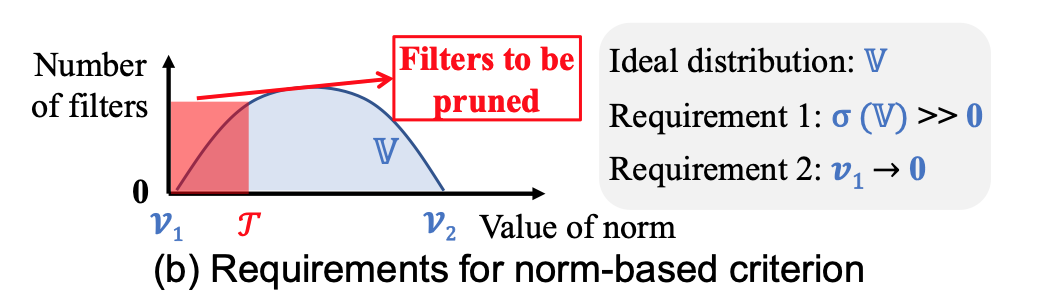
<center>图4-1</center>

而现实中的模型的权重分布如图4-2中绿色分布所示，总是有较小的偏差或较大的最小值。

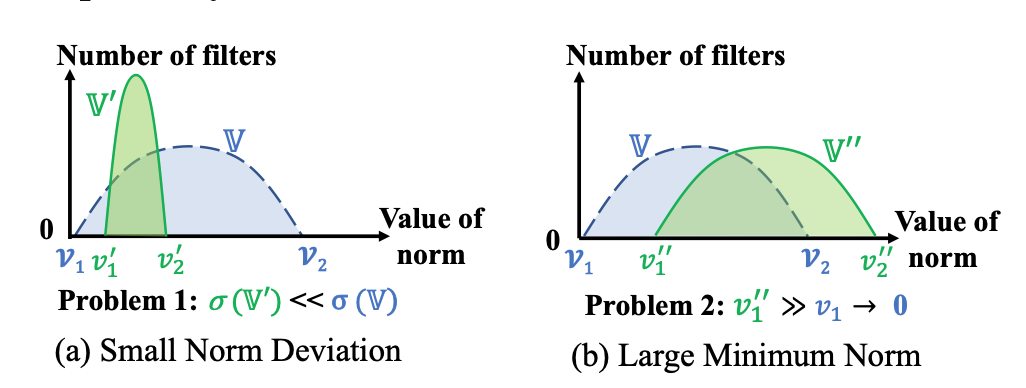
<center>图4-2</center>

考虑到上述传统方法的缺点，FPGM则用filter之间的几何距离来表示重要性，其遵循的原则就是：几何距离比较近的filters，作用也相近。
如图4-3所示，有3个filters，将各个filter展开为向量，并两两计算几何距离。其中，绿色filter的重要性得分就是它到其它两个filter的距离和，即0.7071+0.5831=1.2902。同理算出另外两个filters的得分，绿色filter得分最高，其重要性最高。

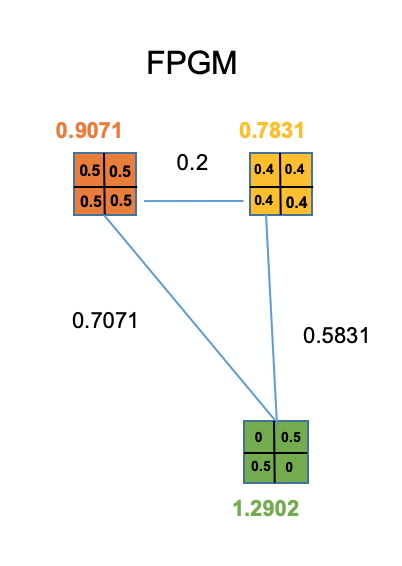
<center>图4-3</center>

### 4.2 实现

以下代码通过继承`FilterPruner`并重载`cal_mask`实现了`FPGMFilterPruner`，其中，`get_distance_sum`用于计算第`out_idx`个filter的重要性。

In [6]:
import numpy as np
from paddleslim.dygraph import FilterPruner

class FPGMFilterPruner(FilterPruner):
    def cal_mask(self, var_name, pruned_ratio, group):
        value = group[var_name]['value']
        pruned_dims = group[var_name]['pruned_dims']
        assert(pruned_dims == [0])
        
        dist_sum_list = []
        for out_i in range(value.shape[0]):
            dist_sum = self.get_distance_sum(value, out_i)
            dist_sum_list.append(dist_sum)
        scores = np.array(dist_sum_list)
        
        sorted_idx = scores.argsort()
        pruned_num = int(round(len(sorted_idx) * pruned_ratio))
        pruned_idx = sorted_idx[:pruned_num]
        mask_shape = [value.shape[i] for i in pruned_dims]
        mask = np.ones(mask_shape, dtype="int32")
        mask[pruned_idx] = 0
        return mask
    
    def get_distance_sum(self, value, out_idx):
        w = value.view()
        w.shape = value.shape[0], np.product(value.shape[1:])
        selected_filter = np.tile(w[out_idx], (w.shape[0], 1))
        x = w - selected_filter
        x = np.sqrt(np.sum(x * x, -1))
        return x.sum()

接下来声明一个`FPGMFilterPruner`对象进行验证:

In [7]:
pruner = FPGMFilterPruner(net, [1, 3, 32, 32])
plan = pruner.prune_var("conv2d_0.w_0", 0, 0.5)
print(plan)
pruner.restore()

2020-11-23 14:29:01,500-INFO: Parsing model with input: [1, 3, 32, 32]


src : None


2020-11-23 14:29:02,016-INFO: No walker for operator: matmul
2020-11-23 14:29:02,031-INFO: Found 14 groups.
2020-11-23 14:29:02,033-INFO: Parsing model with input: [1, 3, 32, 32]
2020-11-23 14:29:02,757-INFO: No walker for operator: matmul
2020-11-23 14:29:02,771-INFO: Found 14 groups.


variable name	pruned ratio	pruned dims
conv2d_0.w_0:	0.5	[0]
batch_norm2d_0.w_0:	0.5	[0]
batch_norm2d_0.b_0:	0.5	[0]
batch_norm2d_0.w_1:	0.5	[0]
batch_norm2d_0.w_2:	0.5	[0]
conv2d_1.w_0:	0.5	[0]
batch_norm2d_1.w_0:	0.5	[0]
batch_norm2d_1.b_0:	0.5	[0]
batch_norm2d_1.w_1:	0.5	[0]
batch_norm2d_1.w_2:	0.5	[0]
conv2d_2.w_0:	0.5	[1]
pruned FLOPs: None


## 5. 敏感度剪裁

在第3节和第4节，开发者自定义实现的`L2NormFilterPruner`和`FPGMFilterPruner`也继承了`FilterPruner`的敏感度计算方法`sensitive`和剪裁方法`sensitive_prune`。

### 5.1 预训练

In [9]:
import paddle.vision.transforms as T
transform = T.Compose([
                    T.Transpose(),
                    T.Normalize([127.5], [127.5])
                ])
train_dataset = paddle.vision.datasets.Cifar10(mode="train", backend="cv2",transform=transform)
val_dataset = paddle.vision.datasets.Cifar10(mode="test", backend="cv2",transform=transform)
from paddle.static import InputSpec as Input
optimizer = paddle.optimizer.Momentum(
        learning_rate=0.1,
        parameters=net.parameters())

inputs = [Input([None, 3, 32, 32], 'float32', name='image')]
labels = [Input([None, 1], 'int64', name='label')]
model = paddle.Model(net, inputs, labels)
model.prepare(
        optimizer,
        paddle.nn.CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1, 5)))
model.fit(train_dataset, epochs=2, batch_size=128, verbose=1)
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(result)

Epoch 1/2


/root/miniconda3/lib/python3.8/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  return (isinstance(seq, collections.Sequence) and


step   391/50000 [..............................] - loss: 1.5899 - acc_top1: 0.3404 - acc_top5: 0.8369 - ETA: 37:46 - 46ms/stepEpoch 2/2
step   391/50000 [..............................] - loss: 1.5950 - acc_top1: 0.4640 - acc_top5: 0.9193 - ETA: 34:11 - 41ms/step

### 5.2 计算敏感度

In [11]:
pruner = FPGMFilterPruner(net, [1, 3, 32, 32])
def eval_fn():
        result = model.evaluate(
            val_dataset,
            batch_size=128)
        return result['acc_top1']
sen = pruner.sensitive(eval_func=eval_fn, sen_file="./fpgm_sen.pickle")
print(sen)

2020-11-24 03:24:15,281-INFO: Parsing model with input: [1, 3, 32, 32]


src : None


2020-11-24 03:24:15,723-INFO: No walker for operator: matmul
2020-11-24 03:24:15,736-INFO: Found 14 groups.
2020-11-24 03:24:15,738-INFO: Parsing model with input: [1, 3, 32, 32]
2020-11-24 03:24:16,161-INFO: No walker for operator: matmul
2020-11-24 03:24:16,174-INFO: Found 14 groups.


Eval begin...
step    10/10000 - loss: 2.0622 - acc_top1: 0.3578 - acc_top5: 0.8820 - 29ms/step
step    20/10000 - loss: 2.4804 - acc_top1: 0.3563 - acc_top5: 0.8809 - 30ms/step
step    30/10000 - loss: 1.9870 - acc_top1: 0.3630 - acc_top5: 0.8799 - 28ms/step
step    40/10000 - loss: 2.0306 - acc_top1: 0.3600 - acc_top5: 0.8805 - 28ms/step
step    50/10000 - loss: 1.9213 - acc_top1: 0.3580 - acc_top5: 0.8772 - 27ms/step
step    60/10000 - loss: 2.0147 - acc_top1: 0.3583 - acc_top5: 0.8783 - 26ms/step
step    70/10000 - loss: 1.7145 - acc_top1: 0.3576 - acc_top5: 0.8767 - 28ms/step
step    79/10000 - loss: 2.0941 - acc_top1: 0.3550 - acc_top5: 0.8776 - 28ms/step
Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0785 - acc_top1: 0.3141 - acc_top5: 0.8102 - 32ms/step
step    20/10000 - loss: 2.2868 - acc_top1: 0.3059 - acc_top5: 0.8160 - 31ms/step
step    30/10000 - loss: 2.0409 - acc_top1: 0.3083 - acc_top5: 0.8143 - 31ms/step
step    40/10000 - loss: 2.0450 - acc_top1: 0.3105

2020-11-24 03:24:20,509-INFO: pruned param: conv2d_0.w_0; 0.1; loss=0.14056338028169016
2020-11-24 03:24:20,510-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1202 - acc_top1: 0.3070 - acc_top5: 0.7891 - 32ms/step
step    20/10000 - loss: 2.3285 - acc_top1: 0.2965 - acc_top5: 0.7953 - 29ms/step
step    30/10000 - loss: 2.0903 - acc_top1: 0.2977 - acc_top5: 0.7901 - 28ms/step
step    40/10000 - loss: 2.1288 - acc_top1: 0.2980 - acc_top5: 0.7881 - 27ms/step
step    50/10000 - loss: 2.1990 - acc_top1: 0.2953 - acc_top5: 0.7905 - 27ms/step
step    60/10000 - loss: 2.1840 - acc_top1: 0.2941 - acc_top5: 0.7901 - 27ms/step
step    70/10000 - loss: 2.1300 - acc_top1: 0.2919 - acc_top5: 0.7886 - 26ms/step
step    79/10000 - loss: 2.2664 - acc_top1: 0.2902 - acc_top5: 0.7869 - 26ms/step


2020-11-24 03:24:22,668-INFO: pruned param: conv2d_0.w_0; 0.2; loss=0.18253521126760555
2020-11-24 03:24:22,670-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1213 - acc_top1: 0.2914 - acc_top5: 0.7992 - 30ms/step
step    20/10000 - loss: 2.2015 - acc_top1: 0.2922 - acc_top5: 0.7988 - 29ms/step
step    30/10000 - loss: 2.1253 - acc_top1: 0.2927 - acc_top5: 0.7956 - 28ms/step
step    40/10000 - loss: 2.1326 - acc_top1: 0.2926 - acc_top5: 0.7926 - 28ms/step
step    50/10000 - loss: 2.2587 - acc_top1: 0.2892 - acc_top5: 0.7963 - 28ms/step
step    60/10000 - loss: 2.1891 - acc_top1: 0.2896 - acc_top5: 0.7951 - 28ms/step
step    70/10000 - loss: 2.1368 - acc_top1: 0.2877 - acc_top5: 0.7941 - 28ms/step
step    79/10000 - loss: 2.2128 - acc_top1: 0.2857 - acc_top5: 0.7923 - 28ms/step


2020-11-24 03:24:24,930-INFO: pruned param: conv2d_0.w_0; 0.3; loss=0.19521126760563373
2020-11-24 03:24:24,931-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9680 - acc_top1: 0.3047 - acc_top5: 0.8258 - 31ms/step
step    20/10000 - loss: 2.1272 - acc_top1: 0.2996 - acc_top5: 0.8293 - 41ms/step
step    30/10000 - loss: 2.0002 - acc_top1: 0.2961 - acc_top5: 0.8245 - 45ms/step
step    40/10000 - loss: 2.0440 - acc_top1: 0.2986 - acc_top5: 0.8213 - 40ms/step
step    50/10000 - loss: 2.1436 - acc_top1: 0.2980 - acc_top5: 0.8216 - 37ms/step
step    60/10000 - loss: 2.0198 - acc_top1: 0.2990 - acc_top5: 0.8193 - 36ms/step
step    70/10000 - loss: 2.0258 - acc_top1: 0.2984 - acc_top5: 0.8203 - 35ms/step
step    79/10000 - loss: 1.9027 - acc_top1: 0.2963 - acc_top5: 0.8195 - 33ms/step


2020-11-24 03:24:27,632-INFO: pruned param: conv2d_0.w_0; 0.4; loss=0.16535211267605626
2020-11-24 03:24:27,634-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0214 - acc_top1: 0.2867 - acc_top5: 0.8094 - 28ms/step
step    20/10000 - loss: 2.2389 - acc_top1: 0.2812 - acc_top5: 0.8098 - 29ms/step
step    30/10000 - loss: 2.1163 - acc_top1: 0.2760 - acc_top5: 0.8057 - 33ms/step
step    40/10000 - loss: 2.1814 - acc_top1: 0.2752 - acc_top5: 0.8018 - 33ms/step
step    50/10000 - loss: 2.2442 - acc_top1: 0.2733 - acc_top5: 0.8008 - 33ms/step
step    60/10000 - loss: 2.1441 - acc_top1: 0.2741 - acc_top5: 0.7971 - 32ms/step
step    70/10000 - loss: 2.1222 - acc_top1: 0.2723 - acc_top5: 0.7987 - 32ms/step
step    79/10000 - loss: 1.8553 - acc_top1: 0.2719 - acc_top5: 0.7979 - 32ms/step


2020-11-24 03:24:30,213-INFO: pruned param: conv2d_0.w_0; 0.5; loss=0.23408450704225356
2020-11-24 03:24:30,215-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.9252 - acc_top1: 0.1688 - acc_top5: 0.6180 - 30ms/step
step    20/10000 - loss: 3.1770 - acc_top1: 0.1652 - acc_top5: 0.6238 - 29ms/step
step    30/10000 - loss: 3.0848 - acc_top1: 0.1599 - acc_top5: 0.6281 - 29ms/step
step    40/10000 - loss: 3.3384 - acc_top1: 0.1605 - acc_top5: 0.6211 - 29ms/step
step    50/10000 - loss: 3.1595 - acc_top1: 0.1578 - acc_top5: 0.6152 - 29ms/step
step    60/10000 - loss: 2.9086 - acc_top1: 0.1592 - acc_top5: 0.6167 - 29ms/step
step    70/10000 - loss: 2.9666 - acc_top1: 0.1605 - acc_top5: 0.6180 - 29ms/step
step    79/10000 - loss: 2.8454 - acc_top1: 0.1628 - acc_top5: 0.6187 - 29ms/step


2020-11-24 03:24:32,500-INFO: pruned param: conv2d_0.w_0; 0.6; loss=0.5414084507042253
2020-11-24 03:24:32,502-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.9496 - acc_top1: 0.1672 - acc_top5: 0.6164 - 32ms/step
step    20/10000 - loss: 3.1902 - acc_top1: 0.1656 - acc_top5: 0.6191 - 30ms/step
step    30/10000 - loss: 3.1035 - acc_top1: 0.1599 - acc_top5: 0.6245 - 31ms/step
step    40/10000 - loss: 3.3631 - acc_top1: 0.1609 - acc_top5: 0.6184 - 35ms/step
step    50/10000 - loss: 3.1755 - acc_top1: 0.1581 - acc_top5: 0.6120 - 37ms/step
step    60/10000 - loss: 2.9311 - acc_top1: 0.1595 - acc_top5: 0.6135 - 38ms/step
step    70/10000 - loss: 2.9816 - acc_top1: 0.1608 - acc_top5: 0.6146 - 39ms/step
step    79/10000 - loss: 2.8547 - acc_top1: 0.1630 - acc_top5: 0.6158 - 40ms/step


2020-11-24 03:24:35,645-INFO: pruned param: conv2d_0.w_0; 0.7; loss=0.5408450704225352
2020-11-24 03:24:35,646-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.8581 - acc_top1: 0.1164 - acc_top5: 0.5180 - 45ms/step
step    20/10000 - loss: 2.8238 - acc_top1: 0.1156 - acc_top5: 0.5414 - 44ms/step
step    30/10000 - loss: 2.8146 - acc_top1: 0.1130 - acc_top5: 0.5484 - 39ms/step
step    40/10000 - loss: 2.8655 - acc_top1: 0.1137 - acc_top5: 0.5455 - 36ms/step
step    50/10000 - loss: 2.7496 - acc_top1: 0.1136 - acc_top5: 0.5469 - 34ms/step
step    60/10000 - loss: 3.0027 - acc_top1: 0.1163 - acc_top5: 0.5477 - 33ms/step
step    70/10000 - loss: 2.8917 - acc_top1: 0.1162 - acc_top5: 0.5463 - 32ms/step
step    79/10000 - loss: 2.2504 - acc_top1: 0.1167 - acc_top5: 0.5447 - 31ms/step


2020-11-24 03:24:38,229-INFO: pruned param: conv2d_0.w_0; 0.8; loss=0.6712676056338028
2020-11-24 03:24:38,231-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.2303 - acc_top1: 0.1102 - acc_top5: 0.5055 - 33ms/step
step    20/10000 - loss: 3.3048 - acc_top1: 0.1078 - acc_top5: 0.5051 - 30ms/step
step    30/10000 - loss: 3.4230 - acc_top1: 0.1018 - acc_top5: 0.5057 - 30ms/step
step    40/10000 - loss: 3.4957 - acc_top1: 0.1002 - acc_top5: 0.4996 - 29ms/step
step    50/10000 - loss: 3.2393 - acc_top1: 0.0966 - acc_top5: 0.4998 - 28ms/step
step    60/10000 - loss: 3.3922 - acc_top1: 0.0978 - acc_top5: 0.5012 - 28ms/step
step    70/10000 - loss: 3.2249 - acc_top1: 0.0996 - acc_top5: 0.5010 - 28ms/step
step    79/10000 - loss: 2.8898 - acc_top1: 0.1000 - acc_top5: 0.5000 - 27ms/step


2020-11-24 03:24:40,476-INFO: pruned param: conv2d_0.w_0; 0.9; loss=0.7183098591549296
2020-11-24 03:24:40,478-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1033 - acc_top1: 0.3453 - acc_top5: 0.8844 - 31ms/step
step    20/10000 - loss: 2.4678 - acc_top1: 0.3465 - acc_top5: 0.8816 - 30ms/step
step    30/10000 - loss: 1.9759 - acc_top1: 0.3539 - acc_top5: 0.8797 - 29ms/step
step    40/10000 - loss: 2.0179 - acc_top1: 0.3539 - acc_top5: 0.8801 - 28ms/step
step    50/10000 - loss: 1.9781 - acc_top1: 0.3523 - acc_top5: 0.8783 - 28ms/step
step    60/10000 - loss: 2.0707 - acc_top1: 0.3533 - acc_top5: 0.8790 - 28ms/step
step    70/10000 - loss: 1.7099 - acc_top1: 0.3540 - acc_top5: 0.8777 - 28ms/step
step    79/10000 - loss: 2.2111 - acc_top1: 0.3517 - acc_top5: 0.8780 - 27ms/step


2020-11-24 03:24:42,668-INFO: pruned param: conv2d_2.w_0; 0.1; loss=0.009295774647887238
2020-11-24 03:24:42,670-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1010 - acc_top1: 0.3344 - acc_top5: 0.8812 - 31ms/step
step    20/10000 - loss: 2.4123 - acc_top1: 0.3391 - acc_top5: 0.8789 - 31ms/step
step    30/10000 - loss: 2.1094 - acc_top1: 0.3398 - acc_top5: 0.8758 - 31ms/step
step    40/10000 - loss: 2.0898 - acc_top1: 0.3432 - acc_top5: 0.8748 - 35ms/step
step    50/10000 - loss: 2.0203 - acc_top1: 0.3416 - acc_top5: 0.8741 - 34ms/step
step    60/10000 - loss: 2.1367 - acc_top1: 0.3414 - acc_top5: 0.8741 - 33ms/step
step    70/10000 - loss: 1.8065 - acc_top1: 0.3393 - acc_top5: 0.8732 - 32ms/step
step    79/10000 - loss: 2.3356 - acc_top1: 0.3376 - acc_top5: 0.8729 - 31ms/step


2020-11-24 03:24:45,222-INFO: pruned param: conv2d_2.w_0; 0.2; loss=0.04901408450704217
2020-11-24 03:24:45,223-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0185 - acc_top1: 0.3297 - acc_top5: 0.8758 - 30ms/step
step    20/10000 - loss: 2.3109 - acc_top1: 0.3375 - acc_top5: 0.8730 - 29ms/step
step    30/10000 - loss: 1.9938 - acc_top1: 0.3466 - acc_top5: 0.8698 - 31ms/step
step    40/10000 - loss: 1.9727 - acc_top1: 0.3525 - acc_top5: 0.8701 - 31ms/step
step    50/10000 - loss: 1.9533 - acc_top1: 0.3523 - acc_top5: 0.8697 - 30ms/step
step    60/10000 - loss: 2.0423 - acc_top1: 0.3509 - acc_top5: 0.8695 - 30ms/step
step    70/10000 - loss: 1.7621 - acc_top1: 0.3503 - acc_top5: 0.8680 - 30ms/step
step    79/10000 - loss: 2.1549 - acc_top1: 0.3471 - acc_top5: 0.8678 - 29ms/step


2020-11-24 03:24:47,565-INFO: pruned param: conv2d_2.w_0; 0.3; loss=0.022253521126760458
2020-11-24 03:24:47,567-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1660 - acc_top1: 0.2883 - acc_top5: 0.8664 - 29ms/step
step    20/10000 - loss: 2.4905 - acc_top1: 0.2973 - acc_top5: 0.8652 - 30ms/step
step    30/10000 - loss: 2.1717 - acc_top1: 0.3063 - acc_top5: 0.8594 - 29ms/step
step    40/10000 - loss: 2.2171 - acc_top1: 0.3051 - acc_top5: 0.8564 - 29ms/step
step    50/10000 - loss: 2.0939 - acc_top1: 0.3039 - acc_top5: 0.8569 - 28ms/step
step    60/10000 - loss: 2.2444 - acc_top1: 0.3056 - acc_top5: 0.8574 - 28ms/step
step    70/10000 - loss: 1.8978 - acc_top1: 0.3054 - acc_top5: 0.8570 - 28ms/step
step    79/10000 - loss: 2.2844 - acc_top1: 0.3041 - acc_top5: 0.8570 - 27ms/step


2020-11-24 03:24:49,723-INFO: pruned param: conv2d_2.w_0; 0.4; loss=0.14338028169014086
2020-11-24 03:24:49,724-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.3007 - acc_top1: 0.2727 - acc_top5: 0.8438 - 26ms/step
step    20/10000 - loss: 2.4514 - acc_top1: 0.2891 - acc_top5: 0.8480 - 25ms/step
step    30/10000 - loss: 2.3325 - acc_top1: 0.2904 - acc_top5: 0.8440 - 25ms/step
step    40/10000 - loss: 2.3660 - acc_top1: 0.2904 - acc_top5: 0.8414 - 25ms/step
step    50/10000 - loss: 2.2547 - acc_top1: 0.2911 - acc_top5: 0.8427 - 27ms/step
step    60/10000 - loss: 2.3920 - acc_top1: 0.2930 - acc_top5: 0.8424 - 28ms/step
step    70/10000 - loss: 2.0525 - acc_top1: 0.2913 - acc_top5: 0.8415 - 28ms/step
step    79/10000 - loss: 2.2892 - acc_top1: 0.2899 - acc_top5: 0.8417 - 27ms/step


2020-11-24 03:24:51,938-INFO: pruned param: conv2d_2.w_0; 0.5; loss=0.18338028169014084
2020-11-24 03:24:51,940-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1026 - acc_top1: 0.2805 - acc_top5: 0.8469 - 42ms/step
step    20/10000 - loss: 2.2440 - acc_top1: 0.2914 - acc_top5: 0.8488 - 42ms/step
step    30/10000 - loss: 2.2351 - acc_top1: 0.2958 - acc_top5: 0.8469 - 43ms/step
step    40/10000 - loss: 2.2838 - acc_top1: 0.2961 - acc_top5: 0.8410 - 43ms/step
step    50/10000 - loss: 2.0857 - acc_top1: 0.2927 - acc_top5: 0.8416 - 43ms/step
step    60/10000 - loss: 2.2468 - acc_top1: 0.2931 - acc_top5: 0.8428 - 43ms/step
step    70/10000 - loss: 1.9549 - acc_top1: 0.2908 - acc_top5: 0.8417 - 43ms/step
step    79/10000 - loss: 2.1043 - acc_top1: 0.2908 - acc_top5: 0.8414 - 43ms/step


2020-11-24 03:24:55,385-INFO: pruned param: conv2d_2.w_0; 0.6; loss=0.18084507042253517
2020-11-24 03:24:55,387-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.5966 - acc_top1: 0.2313 - acc_top5: 0.7719 - 30ms/step
step    20/10000 - loss: 2.8213 - acc_top1: 0.2379 - acc_top5: 0.7816 - 29ms/step
step    30/10000 - loss: 2.6604 - acc_top1: 0.2375 - acc_top5: 0.7771 - 29ms/step
step    40/10000 - loss: 2.7646 - acc_top1: 0.2332 - acc_top5: 0.7674 - 29ms/step
step    50/10000 - loss: 2.6162 - acc_top1: 0.2327 - acc_top5: 0.7675 - 30ms/step
step    60/10000 - loss: 2.7366 - acc_top1: 0.2319 - acc_top5: 0.7667 - 29ms/step
step    70/10000 - loss: 2.4342 - acc_top1: 0.2279 - acc_top5: 0.7640 - 29ms/step
step    79/10000 - loss: 2.4614 - acc_top1: 0.2298 - acc_top5: 0.7616 - 29ms/step


2020-11-24 03:24:57,765-INFO: pruned param: conv2d_2.w_0; 0.7; loss=0.3526760563380281
2020-11-24 03:24:57,767-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.3874 - acc_top1: 0.1703 - acc_top5: 0.7031 - 36ms/step
step    20/10000 - loss: 3.2808 - acc_top1: 0.1797 - acc_top5: 0.6926 - 33ms/step
step    30/10000 - loss: 3.3865 - acc_top1: 0.1789 - acc_top5: 0.6833 - 31ms/step
step    40/10000 - loss: 3.3686 - acc_top1: 0.1795 - acc_top5: 0.6816 - 30ms/step
step    50/10000 - loss: 3.2695 - acc_top1: 0.1830 - acc_top5: 0.6863 - 32ms/step
step    60/10000 - loss: 3.5574 - acc_top1: 0.1835 - acc_top5: 0.6861 - 33ms/step
step    70/10000 - loss: 3.0150 - acc_top1: 0.1812 - acc_top5: 0.6855 - 32ms/step
step    79/10000 - loss: 2.9092 - acc_top1: 0.1818 - acc_top5: 0.6842 - 31ms/step


2020-11-24 03:25:00,352-INFO: pruned param: conv2d_2.w_0; 0.8; loss=0.48788732394366197
2020-11-24 03:25:00,353-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 5.0922 - acc_top1: 0.1031 - acc_top5: 0.5414 - 31ms/step
step    20/10000 - loss: 4.7770 - acc_top1: 0.1160 - acc_top5: 0.5406 - 31ms/step
step    30/10000 - loss: 4.8208 - acc_top1: 0.1182 - acc_top5: 0.5378 - 31ms/step
step    40/10000 - loss: 4.9467 - acc_top1: 0.1182 - acc_top5: 0.5328 - 30ms/step
step    50/10000 - loss: 4.7917 - acc_top1: 0.1198 - acc_top5: 0.5380 - 30ms/step
step    60/10000 - loss: 5.1601 - acc_top1: 0.1195 - acc_top5: 0.5367 - 29ms/step
step    70/10000 - loss: 4.5615 - acc_top1: 0.1172 - acc_top5: 0.5372 - 29ms/step
step    79/10000 - loss: 5.0057 - acc_top1: 0.1163 - acc_top5: 0.5359 - 29ms/step


2020-11-24 03:25:02,685-INFO: pruned param: conv2d_2.w_0; 0.9; loss=0.6723943661971831
2020-11-24 03:25:02,686-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0279 - acc_top1: 0.3570 - acc_top5: 0.8852 - 29ms/step
step    20/10000 - loss: 2.4807 - acc_top1: 0.3488 - acc_top5: 0.8812 - 29ms/step
step    30/10000 - loss: 2.0409 - acc_top1: 0.3510 - acc_top5: 0.8784 - 28ms/step
step    40/10000 - loss: 2.0239 - acc_top1: 0.3535 - acc_top5: 0.8789 - 27ms/step
step    50/10000 - loss: 1.9570 - acc_top1: 0.3523 - acc_top5: 0.8761 - 27ms/step
step    60/10000 - loss: 2.0188 - acc_top1: 0.3526 - acc_top5: 0.8772 - 26ms/step
step    70/10000 - loss: 1.7395 - acc_top1: 0.3518 - acc_top5: 0.8762 - 27ms/step
step    79/10000 - loss: 2.0684 - acc_top1: 0.3491 - acc_top5: 0.8762 - 26ms/step


2020-11-24 03:25:04,819-INFO: pruned param: conv2d_4.w_0; 0.1; loss=0.016619718309859047
2020-11-24 03:25:04,821-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8916 - acc_top1: 0.3625 - acc_top5: 0.8789 - 30ms/step
step    20/10000 - loss: 2.3430 - acc_top1: 0.3559 - acc_top5: 0.8785 - 28ms/step
step    30/10000 - loss: 1.9728 - acc_top1: 0.3534 - acc_top5: 0.8729 - 30ms/step
step    40/10000 - loss: 1.9648 - acc_top1: 0.3512 - acc_top5: 0.8730 - 29ms/step
step    50/10000 - loss: 1.8782 - acc_top1: 0.3500 - acc_top5: 0.8717 - 29ms/step
step    60/10000 - loss: 1.9669 - acc_top1: 0.3500 - acc_top5: 0.8727 - 30ms/step
step    70/10000 - loss: 1.7471 - acc_top1: 0.3485 - acc_top5: 0.8719 - 29ms/step
step    79/10000 - loss: 1.8659 - acc_top1: 0.3460 - acc_top5: 0.8716 - 29ms/step


2020-11-24 03:25:07,169-INFO: pruned param: conv2d_4.w_0; 0.2; loss=0.025352112676056363
2020-11-24 03:25:07,171-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8706 - acc_top1: 0.3797 - acc_top5: 0.8789 - 28ms/step
step    20/10000 - loss: 2.2846 - acc_top1: 0.3703 - acc_top5: 0.8793 - 27ms/step
step    30/10000 - loss: 1.9040 - acc_top1: 0.3688 - acc_top5: 0.8758 - 26ms/step
step    40/10000 - loss: 1.8719 - acc_top1: 0.3695 - acc_top5: 0.8764 - 29ms/step
step    50/10000 - loss: 1.8422 - acc_top1: 0.3670 - acc_top5: 0.8734 - 31ms/step
step    60/10000 - loss: 1.9282 - acc_top1: 0.3637 - acc_top5: 0.8750 - 33ms/step
step    70/10000 - loss: 1.7042 - acc_top1: 0.3632 - acc_top5: 0.8760 - 34ms/step
step    79/10000 - loss: 1.8529 - acc_top1: 0.3596 - acc_top5: 0.8765 - 34ms/step


2020-11-24 03:25:09,906-INFO: pruned param: conv2d_4.w_0; 0.3; loss=-0.01295774647887322
2020-11-24 03:25:09,907-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9431 - acc_top1: 0.3508 - acc_top5: 0.8656 - 29ms/step
step    20/10000 - loss: 2.3617 - acc_top1: 0.3367 - acc_top5: 0.8688 - 28ms/step
step    30/10000 - loss: 2.0461 - acc_top1: 0.3326 - acc_top5: 0.8638 - 27ms/step
step    40/10000 - loss: 2.0497 - acc_top1: 0.3338 - acc_top5: 0.8637 - 27ms/step
step    50/10000 - loss: 1.9805 - acc_top1: 0.3311 - acc_top5: 0.8603 - 27ms/step
step    60/10000 - loss: 2.0594 - acc_top1: 0.3319 - acc_top5: 0.8600 - 26ms/step
step    70/10000 - loss: 1.8099 - acc_top1: 0.3301 - acc_top5: 0.8592 - 26ms/step
step    79/10000 - loss: 1.9082 - acc_top1: 0.3275 - acc_top5: 0.8570 - 25ms/step


2020-11-24 03:25:11,988-INFO: pruned param: conv2d_4.w_0; 0.4; loss=0.07746478873239428
2020-11-24 03:25:11,990-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8583 - acc_top1: 0.3469 - acc_top5: 0.8477 - 28ms/step
step    20/10000 - loss: 2.1740 - acc_top1: 0.3383 - acc_top5: 0.8496 - 27ms/step
step    30/10000 - loss: 1.9823 - acc_top1: 0.3333 - acc_top5: 0.8461 - 26ms/step
step    40/10000 - loss: 2.0079 - acc_top1: 0.3289 - acc_top5: 0.8465 - 26ms/step
step    50/10000 - loss: 1.9248 - acc_top1: 0.3255 - acc_top5: 0.8434 - 26ms/step
step    60/10000 - loss: 2.0183 - acc_top1: 0.3276 - acc_top5: 0.8444 - 28ms/step
step    70/10000 - loss: 1.8042 - acc_top1: 0.3269 - acc_top5: 0.8436 - 28ms/step
step    79/10000 - loss: 1.5723 - acc_top1: 0.3242 - acc_top5: 0.8428 - 28ms/step


2020-11-24 03:25:14,216-INFO: pruned param: conv2d_4.w_0; 0.5; loss=0.08676056338028168
2020-11-24 03:25:14,217-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.2101 - acc_top1: 0.2641 - acc_top5: 0.7656 - 31ms/step
step    20/10000 - loss: 2.5949 - acc_top1: 0.2586 - acc_top5: 0.7559 - 28ms/step
step    30/10000 - loss: 2.3376 - acc_top1: 0.2555 - acc_top5: 0.7534 - 29ms/step
step    40/10000 - loss: 2.4214 - acc_top1: 0.2543 - acc_top5: 0.7488 - 30ms/step
step    50/10000 - loss: 2.3310 - acc_top1: 0.2516 - acc_top5: 0.7439 - 30ms/step
step    60/10000 - loss: 2.2879 - acc_top1: 0.2539 - acc_top5: 0.7432 - 32ms/step
step    70/10000 - loss: 2.1598 - acc_top1: 0.2502 - acc_top5: 0.7423 - 32ms/step
step    79/10000 - loss: 1.7848 - acc_top1: 0.2486 - acc_top5: 0.7418 - 31ms/step


2020-11-24 03:25:16,765-INFO: pruned param: conv2d_4.w_0; 0.6; loss=0.29971830985915493
2020-11-24 03:25:16,766-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1335 - acc_top1: 0.2641 - acc_top5: 0.7477 - 29ms/step
step    20/10000 - loss: 2.3938 - acc_top1: 0.2605 - acc_top5: 0.7480 - 28ms/step
step    30/10000 - loss: 2.3532 - acc_top1: 0.2560 - acc_top5: 0.7464 - 28ms/step
step    40/10000 - loss: 2.3225 - acc_top1: 0.2504 - acc_top5: 0.7443 - 28ms/step
step    50/10000 - loss: 2.2453 - acc_top1: 0.2445 - acc_top5: 0.7406 - 28ms/step
step    60/10000 - loss: 2.2345 - acc_top1: 0.2471 - acc_top5: 0.7414 - 29ms/step
step    70/10000 - loss: 2.1778 - acc_top1: 0.2432 - acc_top5: 0.7430 - 28ms/step
step    79/10000 - loss: 1.7666 - acc_top1: 0.2421 - acc_top5: 0.7411 - 27ms/step


2020-11-24 03:25:18,994-INFO: pruned param: conv2d_4.w_0; 0.7; loss=0.3180281690140844
2020-11-24 03:25:18,996-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.3344 - acc_top1: 0.1859 - acc_top5: 0.6398 - 28ms/step
step    20/10000 - loss: 2.5736 - acc_top1: 0.1820 - acc_top5: 0.6480 - 28ms/step
step    30/10000 - loss: 2.6959 - acc_top1: 0.1766 - acc_top5: 0.6469 - 32ms/step
step    40/10000 - loss: 2.6809 - acc_top1: 0.1756 - acc_top5: 0.6422 - 32ms/step
step    50/10000 - loss: 2.5630 - acc_top1: 0.1733 - acc_top5: 0.6381 - 30ms/step
step    60/10000 - loss: 2.4646 - acc_top1: 0.1750 - acc_top5: 0.6408 - 30ms/step
step    70/10000 - loss: 2.4065 - acc_top1: 0.1749 - acc_top5: 0.6429 - 30ms/step
step    79/10000 - loss: 2.2403 - acc_top1: 0.1744 - acc_top5: 0.6416 - 29ms/step


2020-11-24 03:25:21,405-INFO: pruned param: conv2d_4.w_0; 0.8; loss=0.5087323943661971
2020-11-24 03:25:21,406-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.4639 - acc_top1: 0.1422 - acc_top5: 0.5539 - 42ms/step
step    20/10000 - loss: 2.5937 - acc_top1: 0.1457 - acc_top5: 0.5531 - 33ms/step
step    30/10000 - loss: 2.7672 - acc_top1: 0.1414 - acc_top5: 0.5500 - 30ms/step
step    40/10000 - loss: 2.8011 - acc_top1: 0.1402 - acc_top5: 0.5447 - 30ms/step
step    50/10000 - loss: 2.6704 - acc_top1: 0.1381 - acc_top5: 0.5413 - 30ms/step
step    60/10000 - loss: 2.6573 - acc_top1: 0.1404 - acc_top5: 0.5447 - 30ms/step
step    70/10000 - loss: 2.5044 - acc_top1: 0.1387 - acc_top5: 0.5416 - 30ms/step
step    79/10000 - loss: 2.3958 - acc_top1: 0.1395 - acc_top5: 0.5404 - 29ms/step


2020-11-24 03:25:23,779-INFO: pruned param: conv2d_4.w_0; 0.9; loss=0.6070422535211267
2020-11-24 03:25:23,780-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9542 - acc_top1: 0.3812 - acc_top5: 0.8836 - 39ms/step
step    20/10000 - loss: 2.3695 - acc_top1: 0.3762 - acc_top5: 0.8848 - 35ms/step
step    30/10000 - loss: 1.9230 - acc_top1: 0.3760 - acc_top5: 0.8862 - 33ms/step
step    40/10000 - loss: 1.9379 - acc_top1: 0.3744 - acc_top5: 0.8861 - 33ms/step
step    50/10000 - loss: 1.8656 - acc_top1: 0.3727 - acc_top5: 0.8847 - 34ms/step
step    60/10000 - loss: 1.9242 - acc_top1: 0.3745 - acc_top5: 0.8859 - 36ms/step
step    70/10000 - loss: 1.6630 - acc_top1: 0.3722 - acc_top5: 0.8854 - 37ms/step
step    79/10000 - loss: 2.0082 - acc_top1: 0.3700 - acc_top5: 0.8860 - 37ms/step


2020-11-24 03:25:26,821-INFO: pruned param: conv2d_6.w_0; 0.1; loss=-0.042253521126760604
2020-11-24 03:25:26,823-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9659 - acc_top1: 0.3906 - acc_top5: 0.8844 - 44ms/step
step    20/10000 - loss: 2.4068 - acc_top1: 0.3734 - acc_top5: 0.8844 - 40ms/step
step    30/10000 - loss: 1.9590 - acc_top1: 0.3742 - acc_top5: 0.8812 - 37ms/step
step    40/10000 - loss: 1.9825 - acc_top1: 0.3736 - acc_top5: 0.8822 - 35ms/step
step    50/10000 - loss: 1.8749 - acc_top1: 0.3714 - acc_top5: 0.8816 - 34ms/step
step    60/10000 - loss: 1.9484 - acc_top1: 0.3719 - acc_top5: 0.8832 - 34ms/step
step    70/10000 - loss: 1.6879 - acc_top1: 0.3708 - acc_top5: 0.8825 - 33ms/step
step    79/10000 - loss: 2.0162 - acc_top1: 0.3694 - acc_top5: 0.8825 - 32ms/step


2020-11-24 03:25:29,419-INFO: pruned param: conv2d_6.w_0; 0.2; loss=-0.04056338028169021
2020-11-24 03:25:29,420-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8639 - acc_top1: 0.3937 - acc_top5: 0.8938 - 27ms/step
step    20/10000 - loss: 2.3141 - acc_top1: 0.3875 - acc_top5: 0.8906 - 27ms/step
step    30/10000 - loss: 1.8509 - acc_top1: 0.3888 - acc_top5: 0.8862 - 27ms/step
step    40/10000 - loss: 1.8472 - acc_top1: 0.3855 - acc_top5: 0.8879 - 29ms/step
step    50/10000 - loss: 1.7572 - acc_top1: 0.3816 - acc_top5: 0.8858 - 31ms/step
step    60/10000 - loss: 1.8254 - acc_top1: 0.3818 - acc_top5: 0.8883 - 33ms/step
step    70/10000 - loss: 1.6678 - acc_top1: 0.3816 - acc_top5: 0.8865 - 34ms/step
step    79/10000 - loss: 1.9836 - acc_top1: 0.3799 - acc_top5: 0.8866 - 33ms/step


2020-11-24 03:25:32,041-INFO: pruned param: conv2d_6.w_0; 0.3; loss=-0.07014084507042263
2020-11-24 03:25:32,042-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8957 - acc_top1: 0.3828 - acc_top5: 0.8945 - 34ms/step
step    20/10000 - loss: 2.2738 - acc_top1: 0.3766 - acc_top5: 0.8867 - 32ms/step
step    30/10000 - loss: 1.8877 - acc_top1: 0.3784 - acc_top5: 0.8789 - 32ms/step
step    40/10000 - loss: 1.8979 - acc_top1: 0.3791 - acc_top5: 0.8809 - 33ms/step
step    50/10000 - loss: 1.7464 - acc_top1: 0.3752 - acc_top5: 0.8786 - 32ms/step
step    60/10000 - loss: 1.8625 - acc_top1: 0.3742 - acc_top5: 0.8793 - 31ms/step
step    70/10000 - loss: 1.6911 - acc_top1: 0.3735 - acc_top5: 0.8785 - 31ms/step
step    79/10000 - loss: 1.9278 - acc_top1: 0.3725 - acc_top5: 0.8792 - 30ms/step


2020-11-24 03:25:34,505-INFO: pruned param: conv2d_6.w_0; 0.4; loss=-0.04929577464788737
2020-11-24 03:25:34,506-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8462 - acc_top1: 0.3602 - acc_top5: 0.8766 - 33ms/step
step    20/10000 - loss: 2.2261 - acc_top1: 0.3543 - acc_top5: 0.8730 - 31ms/step
step    30/10000 - loss: 1.9037 - acc_top1: 0.3594 - acc_top5: 0.8628 - 30ms/step
step    40/10000 - loss: 1.9349 - acc_top1: 0.3564 - acc_top5: 0.8641 - 30ms/step
step    50/10000 - loss: 1.7711 - acc_top1: 0.3534 - acc_top5: 0.8620 - 29ms/step
step    60/10000 - loss: 1.8252 - acc_top1: 0.3536 - acc_top5: 0.8630 - 29ms/step
step    70/10000 - loss: 1.7435 - acc_top1: 0.3531 - acc_top5: 0.8631 - 29ms/step
step    79/10000 - loss: 1.7078 - acc_top1: 0.3508 - acc_top5: 0.8630 - 28ms/step


2020-11-24 03:25:36,796-INFO: pruned param: conv2d_6.w_0; 0.5; loss=0.011830985915492906
2020-11-24 03:25:36,798-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8545 - acc_top1: 0.3312 - acc_top5: 0.8766 - 28ms/step
step    20/10000 - loss: 2.1723 - acc_top1: 0.3387 - acc_top5: 0.8691 - 27ms/step
step    30/10000 - loss: 1.7938 - acc_top1: 0.3471 - acc_top5: 0.8612 - 26ms/step
step    40/10000 - loss: 1.8500 - acc_top1: 0.3488 - acc_top5: 0.8602 - 26ms/step
step    50/10000 - loss: 1.7434 - acc_top1: 0.3478 - acc_top5: 0.8578 - 26ms/step
step    60/10000 - loss: 1.8047 - acc_top1: 0.3479 - acc_top5: 0.8581 - 27ms/step
step    70/10000 - loss: 1.7171 - acc_top1: 0.3484 - acc_top5: 0.8596 - 27ms/step
step    79/10000 - loss: 1.9027 - acc_top1: 0.3434 - acc_top5: 0.8588 - 27ms/step


2020-11-24 03:25:38,932-INFO: pruned param: conv2d_6.w_0; 0.6; loss=0.03267605633802817
2020-11-24 03:25:38,934-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8892 - acc_top1: 0.2906 - acc_top5: 0.8430 - 32ms/step
step    20/10000 - loss: 1.9924 - acc_top1: 0.3027 - acc_top5: 0.8457 - 28ms/step
step    30/10000 - loss: 1.8820 - acc_top1: 0.3057 - acc_top5: 0.8430 - 28ms/step
step    40/10000 - loss: 1.8724 - acc_top1: 0.3100 - acc_top5: 0.8387 - 28ms/step
step    50/10000 - loss: 1.8452 - acc_top1: 0.3056 - acc_top5: 0.8359 - 28ms/step
step    60/10000 - loss: 1.8153 - acc_top1: 0.3065 - acc_top5: 0.8371 - 28ms/step
step    70/10000 - loss: 1.8278 - acc_top1: 0.3083 - acc_top5: 0.8365 - 29ms/step
step    79/10000 - loss: 1.8149 - acc_top1: 0.3052 - acc_top5: 0.8358 - 29ms/step


2020-11-24 03:25:41,344-INFO: pruned param: conv2d_6.w_0; 0.7; loss=0.14028169014084496
2020-11-24 03:25:41,345-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0360 - acc_top1: 0.2422 - acc_top5: 0.8055 - 33ms/step
step    20/10000 - loss: 2.0852 - acc_top1: 0.2566 - acc_top5: 0.8051 - 32ms/step
step    30/10000 - loss: 2.0526 - acc_top1: 0.2560 - acc_top5: 0.8029 - 35ms/step
step    40/10000 - loss: 2.0386 - acc_top1: 0.2551 - acc_top5: 0.7980 - 36ms/step
step    50/10000 - loss: 1.9743 - acc_top1: 0.2525 - acc_top5: 0.7948 - 36ms/step
step    60/10000 - loss: 1.9357 - acc_top1: 0.2491 - acc_top5: 0.7939 - 36ms/step
step    70/10000 - loss: 1.7949 - acc_top1: 0.2527 - acc_top5: 0.7945 - 36ms/step
step    79/10000 - loss: 1.7863 - acc_top1: 0.2498 - acc_top5: 0.7924 - 35ms/step


2020-11-24 03:25:44,257-INFO: pruned param: conv2d_6.w_0; 0.8; loss=0.29633802816901406
2020-11-24 03:25:44,259-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.4794 - acc_top1: 0.1266 - acc_top5: 0.6328 - 38ms/step
step    20/10000 - loss: 2.5825 - acc_top1: 0.1281 - acc_top5: 0.6406 - 37ms/step
step    30/10000 - loss: 2.6441 - acc_top1: 0.1245 - acc_top5: 0.6440 - 34ms/step
step    40/10000 - loss: 2.6138 - acc_top1: 0.1238 - acc_top5: 0.6457 - 32ms/step
step    50/10000 - loss: 2.5473 - acc_top1: 0.1209 - acc_top5: 0.6419 - 31ms/step
step    60/10000 - loss: 2.4854 - acc_top1: 0.1230 - acc_top5: 0.6428 - 32ms/step
step    70/10000 - loss: 2.3704 - acc_top1: 0.1237 - acc_top5: 0.6438 - 31ms/step
step    79/10000 - loss: 2.3423 - acc_top1: 0.1229 - acc_top5: 0.6436 - 30ms/step


2020-11-24 03:25:46,684-INFO: pruned param: conv2d_6.w_0; 0.9; loss=0.6538028169014084
2020-11-24 03:25:46,686-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0371 - acc_top1: 0.3578 - acc_top5: 0.8758 - 31ms/step
step    20/10000 - loss: 2.4380 - acc_top1: 0.3574 - acc_top5: 0.8742 - 30ms/step
step    30/10000 - loss: 1.9457 - acc_top1: 0.3664 - acc_top5: 0.8742 - 29ms/step
step    40/10000 - loss: 2.0320 - acc_top1: 0.3617 - acc_top5: 0.8740 - 29ms/step
step    50/10000 - loss: 1.9002 - acc_top1: 0.3595 - acc_top5: 0.8714 - 29ms/step
step    60/10000 - loss: 1.9758 - acc_top1: 0.3578 - acc_top5: 0.8724 - 29ms/step
step    70/10000 - loss: 1.6965 - acc_top1: 0.3556 - acc_top5: 0.8711 - 29ms/step
step    79/10000 - loss: 2.0611 - acc_top1: 0.3520 - acc_top5: 0.8719 - 28ms/step


2020-11-24 03:25:48,938-INFO: pruned param: conv2d_8.w_0; 0.1; loss=0.00845070422535212
2020-11-24 03:25:48,939-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9778 - acc_top1: 0.3500 - acc_top5: 0.8703 - 27ms/step
step    20/10000 - loss: 2.3850 - acc_top1: 0.3531 - acc_top5: 0.8723 - 27ms/step
step    30/10000 - loss: 1.8780 - acc_top1: 0.3630 - acc_top5: 0.8724 - 27ms/step
step    40/10000 - loss: 1.9842 - acc_top1: 0.3617 - acc_top5: 0.8732 - 26ms/step
step    50/10000 - loss: 1.8854 - acc_top1: 0.3583 - acc_top5: 0.8702 - 27ms/step
step    60/10000 - loss: 1.9528 - acc_top1: 0.3564 - acc_top5: 0.8716 - 28ms/step
step    70/10000 - loss: 1.6968 - acc_top1: 0.3557 - acc_top5: 0.8706 - 28ms/step
step    79/10000 - loss: 2.1994 - acc_top1: 0.3517 - acc_top5: 0.8709 - 27ms/step


2020-11-24 03:25:51,129-INFO: pruned param: conv2d_8.w_0; 0.2; loss=0.009295774647887238
2020-11-24 03:25:51,130-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9132 - acc_top1: 0.3328 - acc_top5: 0.8695 - 27ms/step
step    20/10000 - loss: 2.2310 - acc_top1: 0.3488 - acc_top5: 0.8723 - 25ms/step
step    30/10000 - loss: 1.8019 - acc_top1: 0.3578 - acc_top5: 0.8698 - 25ms/step
step    40/10000 - loss: 1.9324 - acc_top1: 0.3568 - acc_top5: 0.8711 - 26ms/step
step    50/10000 - loss: 1.7522 - acc_top1: 0.3531 - acc_top5: 0.8678 - 27ms/step
step    60/10000 - loss: 1.8457 - acc_top1: 0.3505 - acc_top5: 0.8686 - 27ms/step
step    70/10000 - loss: 1.7587 - acc_top1: 0.3489 - acc_top5: 0.8669 - 29ms/step
step    79/10000 - loss: 2.0848 - acc_top1: 0.3449 - acc_top5: 0.8670 - 30ms/step


2020-11-24 03:25:53,574-INFO: pruned param: conv2d_8.w_0; 0.3; loss=0.02845070422535211
2020-11-24 03:25:53,575-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8964 - acc_top1: 0.3414 - acc_top5: 0.8727 - 39ms/step
step    20/10000 - loss: 2.2273 - acc_top1: 0.3473 - acc_top5: 0.8734 - 35ms/step
step    30/10000 - loss: 1.8189 - acc_top1: 0.3536 - acc_top5: 0.8703 - 32ms/step
step    40/10000 - loss: 1.9050 - acc_top1: 0.3535 - acc_top5: 0.8707 - 30ms/step
step    50/10000 - loss: 1.7456 - acc_top1: 0.3484 - acc_top5: 0.8681 - 29ms/step
step    60/10000 - loss: 1.8236 - acc_top1: 0.3473 - acc_top5: 0.8681 - 29ms/step
step    70/10000 - loss: 1.7642 - acc_top1: 0.3481 - acc_top5: 0.8662 - 29ms/step
step    79/10000 - loss: 2.0080 - acc_top1: 0.3434 - acc_top5: 0.8663 - 29ms/step


2020-11-24 03:25:55,949-INFO: pruned param: conv2d_8.w_0; 0.4; loss=0.03267605633802817
2020-11-24 03:25:55,952-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8401 - acc_top1: 0.3289 - acc_top5: 0.8633 - 35ms/step
step    20/10000 - loss: 2.1427 - acc_top1: 0.3352 - acc_top5: 0.8633 - 31ms/step
step    30/10000 - loss: 1.8385 - acc_top1: 0.3419 - acc_top5: 0.8625 - 36ms/step
step    40/10000 - loss: 1.9149 - acc_top1: 0.3395 - acc_top5: 0.8623 - 37ms/step
step    50/10000 - loss: 1.7280 - acc_top1: 0.3367 - acc_top5: 0.8589 - 38ms/step
step    60/10000 - loss: 1.8106 - acc_top1: 0.3339 - acc_top5: 0.8599 - 38ms/step
step    70/10000 - loss: 1.7791 - acc_top1: 0.3347 - acc_top5: 0.8584 - 38ms/step
step    79/10000 - loss: 1.9145 - acc_top1: 0.3313 - acc_top5: 0.8584 - 36ms/step


2020-11-24 03:25:58,916-INFO: pruned param: conv2d_8.w_0; 0.5; loss=0.06676056338028169
2020-11-24 03:25:58,917-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9215 - acc_top1: 0.2898 - acc_top5: 0.8398 - 23ms/step
step    20/10000 - loss: 2.1891 - acc_top1: 0.2984 - acc_top5: 0.8313 - 24ms/step
step    30/10000 - loss: 1.9465 - acc_top1: 0.3008 - acc_top5: 0.8328 - 25ms/step
step    40/10000 - loss: 1.9841 - acc_top1: 0.3016 - acc_top5: 0.8342 - 25ms/step
step    50/10000 - loss: 1.8429 - acc_top1: 0.2995 - acc_top5: 0.8297 - 27ms/step
step    60/10000 - loss: 1.8452 - acc_top1: 0.2999 - acc_top5: 0.8309 - 28ms/step
step    70/10000 - loss: 1.8764 - acc_top1: 0.3023 - acc_top5: 0.8295 - 28ms/step
step    79/10000 - loss: 1.8123 - acc_top1: 0.3012 - acc_top5: 0.8294 - 27ms/step


2020-11-24 03:26:01,125-INFO: pruned param: conv2d_8.w_0; 0.6; loss=0.1515492957746478
2020-11-24 03:26:01,126-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9493 - acc_top1: 0.2727 - acc_top5: 0.8234 - 27ms/step
step    20/10000 - loss: 2.2317 - acc_top1: 0.2672 - acc_top5: 0.8184 - 26ms/step
step    30/10000 - loss: 2.0961 - acc_top1: 0.2747 - acc_top5: 0.8180 - 27ms/step
step    40/10000 - loss: 2.0534 - acc_top1: 0.2766 - acc_top5: 0.8223 - 32ms/step
step    50/10000 - loss: 1.9858 - acc_top1: 0.2717 - acc_top5: 0.8166 - 33ms/step
step    60/10000 - loss: 1.9138 - acc_top1: 0.2711 - acc_top5: 0.8180 - 32ms/step
step    70/10000 - loss: 1.9449 - acc_top1: 0.2723 - acc_top5: 0.8162 - 31ms/step
step    79/10000 - loss: 1.9306 - acc_top1: 0.2696 - acc_top5: 0.8153 - 30ms/step


2020-11-24 03:26:03,618-INFO: pruned param: conv2d_8.w_0; 0.7; loss=0.24056338028169008
2020-11-24 03:26:03,619-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0909 - acc_top1: 0.2336 - acc_top5: 0.8109 - 26ms/step
step    20/10000 - loss: 2.2775 - acc_top1: 0.2273 - acc_top5: 0.8047 - 26ms/step
step    30/10000 - loss: 2.1882 - acc_top1: 0.2328 - acc_top5: 0.8029 - 31ms/step
step    40/10000 - loss: 2.1559 - acc_top1: 0.2354 - acc_top5: 0.8055 - 34ms/step
step    50/10000 - loss: 2.0924 - acc_top1: 0.2325 - acc_top5: 0.8019 - 33ms/step
step    60/10000 - loss: 1.9784 - acc_top1: 0.2340 - acc_top5: 0.8022 - 32ms/step
step    70/10000 - loss: 2.0491 - acc_top1: 0.2343 - acc_top5: 0.8003 - 32ms/step
step    79/10000 - loss: 1.9310 - acc_top1: 0.2318 - acc_top5: 0.7999 - 31ms/step


2020-11-24 03:26:06,117-INFO: pruned param: conv2d_8.w_0; 0.8; loss=0.3470422535211267
2020-11-24 03:26:06,119-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0499 - acc_top1: 0.2141 - acc_top5: 0.7672 - 30ms/step
step    20/10000 - loss: 2.2154 - acc_top1: 0.2113 - acc_top5: 0.7656 - 32ms/step
step    30/10000 - loss: 2.0893 - acc_top1: 0.2174 - acc_top5: 0.7711 - 33ms/step
step    40/10000 - loss: 2.1027 - acc_top1: 0.2188 - acc_top5: 0.7721 - 33ms/step
step    50/10000 - loss: 2.0594 - acc_top1: 0.2159 - acc_top5: 0.7678 - 32ms/step
step    60/10000 - loss: 1.9942 - acc_top1: 0.2178 - acc_top5: 0.7697 - 31ms/step
step    70/10000 - loss: 2.1126 - acc_top1: 0.2193 - acc_top5: 0.7676 - 31ms/step
step    79/10000 - loss: 1.7577 - acc_top1: 0.2165 - acc_top5: 0.7688 - 31ms/step


2020-11-24 03:26:08,616-INFO: pruned param: conv2d_8.w_0; 0.9; loss=0.3901408450704225
2020-11-24 03:26:08,617-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0603 - acc_top1: 0.3438 - acc_top5: 0.8789 - 29ms/step
step    20/10000 - loss: 2.4566 - acc_top1: 0.3469 - acc_top5: 0.8746 - 34ms/step
step    30/10000 - loss: 1.9746 - acc_top1: 0.3526 - acc_top5: 0.8734 - 32ms/step
step    40/10000 - loss: 2.0443 - acc_top1: 0.3488 - acc_top5: 0.8744 - 32ms/step
step    50/10000 - loss: 1.9222 - acc_top1: 0.3459 - acc_top5: 0.8720 - 31ms/step
step    60/10000 - loss: 2.0121 - acc_top1: 0.3458 - acc_top5: 0.8729 - 32ms/step
step    70/10000 - loss: 1.7264 - acc_top1: 0.3446 - acc_top5: 0.8729 - 33ms/step
step    79/10000 - loss: 2.0284 - acc_top1: 0.3423 - acc_top5: 0.8732 - 34ms/step


2020-11-24 03:26:11,396-INFO: pruned param: conv2d_10.w_0; 0.1; loss=0.035774647887323915
2020-11-24 03:26:11,398-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9688 - acc_top1: 0.3484 - acc_top5: 0.8820 - 45ms/step
step    20/10000 - loss: 2.3322 - acc_top1: 0.3500 - acc_top5: 0.8812 - 43ms/step
step    30/10000 - loss: 1.9135 - acc_top1: 0.3563 - acc_top5: 0.8781 - 40ms/step
step    40/10000 - loss: 1.9644 - acc_top1: 0.3527 - acc_top5: 0.8773 - 38ms/step
step    50/10000 - loss: 1.8688 - acc_top1: 0.3495 - acc_top5: 0.8745 - 36ms/step
step    60/10000 - loss: 1.9457 - acc_top1: 0.3480 - acc_top5: 0.8746 - 34ms/step
step    70/10000 - loss: 1.7117 - acc_top1: 0.3462 - acc_top5: 0.8737 - 34ms/step
step    79/10000 - loss: 1.9890 - acc_top1: 0.3434 - acc_top5: 0.8751 - 34ms/step


2020-11-24 03:26:14,234-INFO: pruned param: conv2d_10.w_0; 0.2; loss=0.03267605633802817
2020-11-24 03:26:14,236-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8714 - acc_top1: 0.3352 - acc_top5: 0.8758 - 36ms/step
step    20/10000 - loss: 2.1180 - acc_top1: 0.3383 - acc_top5: 0.8793 - 35ms/step
step    30/10000 - loss: 1.8368 - acc_top1: 0.3440 - acc_top5: 0.8766 - 35ms/step
step    40/10000 - loss: 1.9468 - acc_top1: 0.3424 - acc_top5: 0.8748 - 35ms/step
step    50/10000 - loss: 1.7816 - acc_top1: 0.3392 - acc_top5: 0.8703 - 35ms/step
step    60/10000 - loss: 1.8480 - acc_top1: 0.3387 - acc_top5: 0.8685 - 34ms/step
step    70/10000 - loss: 1.7354 - acc_top1: 0.3383 - acc_top5: 0.8669 - 34ms/step
step    79/10000 - loss: 1.9304 - acc_top1: 0.3348 - acc_top5: 0.8672 - 34ms/step


2020-11-24 03:26:17,019-INFO: pruned param: conv2d_10.w_0; 0.3; loss=0.05690140845070422
2020-11-24 03:26:17,021-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8571 - acc_top1: 0.3312 - acc_top5: 0.8688 - 41ms/step
step    20/10000 - loss: 2.0864 - acc_top1: 0.3395 - acc_top5: 0.8711 - 34ms/step
step    30/10000 - loss: 1.7953 - acc_top1: 0.3417 - acc_top5: 0.8711 - 32ms/step
step    40/10000 - loss: 1.9408 - acc_top1: 0.3410 - acc_top5: 0.8688 - 30ms/step
step    50/10000 - loss: 1.7829 - acc_top1: 0.3359 - acc_top5: 0.8658 - 29ms/step
step    60/10000 - loss: 1.8314 - acc_top1: 0.3358 - acc_top5: 0.8656 - 29ms/step
step    70/10000 - loss: 1.7554 - acc_top1: 0.3343 - acc_top5: 0.8637 - 29ms/step
step    79/10000 - loss: 1.8617 - acc_top1: 0.3317 - acc_top5: 0.8644 - 28ms/step


2020-11-24 03:26:19,384-INFO: pruned param: conv2d_10.w_0; 0.4; loss=0.06563380281690137
2020-11-24 03:26:19,385-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8334 - acc_top1: 0.3336 - acc_top5: 0.8555 - 31ms/step
step    20/10000 - loss: 2.0108 - acc_top1: 0.3348 - acc_top5: 0.8633 - 31ms/step
step    30/10000 - loss: 1.7511 - acc_top1: 0.3378 - acc_top5: 0.8638 - 31ms/step
step    40/10000 - loss: 1.9377 - acc_top1: 0.3348 - acc_top5: 0.8623 - 33ms/step
step    50/10000 - loss: 1.7670 - acc_top1: 0.3314 - acc_top5: 0.8623 - 33ms/step
step    60/10000 - loss: 1.7835 - acc_top1: 0.3320 - acc_top5: 0.8637 - 33ms/step
step    70/10000 - loss: 1.7571 - acc_top1: 0.3310 - acc_top5: 0.8614 - 32ms/step
step    79/10000 - loss: 1.8263 - acc_top1: 0.3284 - acc_top5: 0.8608 - 33ms/step


2020-11-24 03:26:22,107-INFO: pruned param: conv2d_10.w_0; 0.5; loss=0.07492957746478862
2020-11-24 03:26:22,109-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8777 - acc_top1: 0.3250 - acc_top5: 0.8484 - 39ms/step
step    20/10000 - loss: 2.0469 - acc_top1: 0.3195 - acc_top5: 0.8555 - 35ms/step
step    30/10000 - loss: 1.8250 - acc_top1: 0.3229 - acc_top5: 0.8529 - 33ms/step
step    40/10000 - loss: 1.9913 - acc_top1: 0.3187 - acc_top5: 0.8521 - 33ms/step
step    50/10000 - loss: 1.8373 - acc_top1: 0.3130 - acc_top5: 0.8497 - 32ms/step
step    60/10000 - loss: 1.8095 - acc_top1: 0.3118 - acc_top5: 0.8503 - 32ms/step
step    70/10000 - loss: 1.8405 - acc_top1: 0.3109 - acc_top5: 0.8483 - 31ms/step
step    79/10000 - loss: 1.8410 - acc_top1: 0.3086 - acc_top5: 0.8477 - 31ms/step


2020-11-24 03:26:24,699-INFO: pruned param: conv2d_10.w_0; 0.6; loss=0.13070422535211268
2020-11-24 03:26:24,700-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8777 - acc_top1: 0.3070 - acc_top5: 0.8414 - 30ms/step
step    20/10000 - loss: 2.0470 - acc_top1: 0.3020 - acc_top5: 0.8469 - 28ms/step
step    30/10000 - loss: 1.8713 - acc_top1: 0.3104 - acc_top5: 0.8448 - 27ms/step
step    40/10000 - loss: 2.0297 - acc_top1: 0.3082 - acc_top5: 0.8457 - 27ms/step
step    50/10000 - loss: 1.8548 - acc_top1: 0.3025 - acc_top5: 0.8420 - 27ms/step
step    60/10000 - loss: 1.8295 - acc_top1: 0.3026 - acc_top5: 0.8432 - 27ms/step
step    70/10000 - loss: 1.9021 - acc_top1: 0.3006 - acc_top5: 0.8423 - 27ms/step
step    79/10000 - loss: 1.8706 - acc_top1: 0.2990 - acc_top5: 0.8414 - 26ms/step


2020-11-24 03:26:26,882-INFO: pruned param: conv2d_10.w_0; 0.7; loss=0.15774647887323942
2020-11-24 03:26:26,883-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0619 - acc_top1: 0.2062 - acc_top5: 0.7773 - 30ms/step
step    20/10000 - loss: 2.3240 - acc_top1: 0.1988 - acc_top5: 0.7758 - 31ms/step
step    30/10000 - loss: 2.1677 - acc_top1: 0.1995 - acc_top5: 0.7721 - 30ms/step
step    40/10000 - loss: 2.3192 - acc_top1: 0.1973 - acc_top5: 0.7650 - 29ms/step
step    50/10000 - loss: 2.1317 - acc_top1: 0.1922 - acc_top5: 0.7611 - 29ms/step
step    60/10000 - loss: 2.0658 - acc_top1: 0.1948 - acc_top5: 0.7630 - 29ms/step
step    70/10000 - loss: 2.2628 - acc_top1: 0.1962 - acc_top5: 0.7634 - 29ms/step
step    79/10000 - loss: 1.9637 - acc_top1: 0.1955 - acc_top5: 0.7620 - 28ms/step


2020-11-24 03:26:29,210-INFO: pruned param: conv2d_10.w_0; 0.8; loss=0.4492957746478873
2020-11-24 03:26:29,211-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.3602 - acc_top1: 0.1484 - acc_top5: 0.6289 - 30ms/step
step    20/10000 - loss: 2.6376 - acc_top1: 0.1422 - acc_top5: 0.6266 - 29ms/step
step    30/10000 - loss: 2.5771 - acc_top1: 0.1414 - acc_top5: 0.6266 - 29ms/step
step    40/10000 - loss: 2.6645 - acc_top1: 0.1416 - acc_top5: 0.6246 - 29ms/step
step    50/10000 - loss: 2.5523 - acc_top1: 0.1366 - acc_top5: 0.6198 - 30ms/step
step    60/10000 - loss: 2.4306 - acc_top1: 0.1379 - acc_top5: 0.6216 - 29ms/step
step    70/10000 - loss: 2.6041 - acc_top1: 0.1400 - acc_top5: 0.6247 - 29ms/step
step    79/10000 - loss: 2.2214 - acc_top1: 0.1388 - acc_top5: 0.6237 - 28ms/step


2020-11-24 03:26:31,535-INFO: pruned param: conv2d_10.w_0; 0.9; loss=0.6090140845070422
2020-11-24 03:26:31,537-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0362 - acc_top1: 0.3492 - acc_top5: 0.8812 - 30ms/step
step    20/10000 - loss: 2.4428 - acc_top1: 0.3473 - acc_top5: 0.8793 - 30ms/step
step    30/10000 - loss: 1.9417 - acc_top1: 0.3521 - acc_top5: 0.8768 - 29ms/step
step    40/10000 - loss: 2.0333 - acc_top1: 0.3492 - acc_top5: 0.8756 - 28ms/step
step    50/10000 - loss: 1.9037 - acc_top1: 0.3477 - acc_top5: 0.8731 - 28ms/step
step    60/10000 - loss: 2.0053 - acc_top1: 0.3480 - acc_top5: 0.8747 - 28ms/step
step    70/10000 - loss: 1.7041 - acc_top1: 0.3478 - acc_top5: 0.8738 - 28ms/step
step    79/10000 - loss: 2.0897 - acc_top1: 0.3443 - acc_top5: 0.8753 - 28ms/step


2020-11-24 03:26:33,931-INFO: pruned param: conv2d_12.w_0; 0.1; loss=0.0301408450704225
2020-11-24 03:26:33,932-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9852 - acc_top1: 0.3406 - acc_top5: 0.8773 - 30ms/step
step    20/10000 - loss: 2.3378 - acc_top1: 0.3406 - acc_top5: 0.8750 - 29ms/step
step    30/10000 - loss: 1.9016 - acc_top1: 0.3445 - acc_top5: 0.8729 - 28ms/step
step    40/10000 - loss: 1.9959 - acc_top1: 0.3434 - acc_top5: 0.8727 - 28ms/step
step    50/10000 - loss: 1.8351 - acc_top1: 0.3423 - acc_top5: 0.8697 - 31ms/step
step    60/10000 - loss: 1.9585 - acc_top1: 0.3406 - acc_top5: 0.8707 - 30ms/step
step    70/10000 - loss: 1.7213 - acc_top1: 0.3420 - acc_top5: 0.8700 - 31ms/step
step    79/10000 - loss: 2.0173 - acc_top1: 0.3378 - acc_top5: 0.8704 - 30ms/step


2020-11-24 03:26:36,501-INFO: pruned param: conv2d_12.w_0; 0.2; loss=0.048450704225352095
2020-11-24 03:26:36,502-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0290 - acc_top1: 0.3148 - acc_top5: 0.8672 - 33ms/step
step    20/10000 - loss: 2.3569 - acc_top1: 0.3117 - acc_top5: 0.8617 - 38ms/step
step    30/10000 - loss: 1.9626 - acc_top1: 0.3190 - acc_top5: 0.8607 - 39ms/step
step    40/10000 - loss: 2.0515 - acc_top1: 0.3197 - acc_top5: 0.8596 - 38ms/step
step    50/10000 - loss: 1.8659 - acc_top1: 0.3177 - acc_top5: 0.8584 - 39ms/step
step    60/10000 - loss: 1.9999 - acc_top1: 0.3176 - acc_top5: 0.8586 - 37ms/step
step    70/10000 - loss: 1.7603 - acc_top1: 0.3196 - acc_top5: 0.8586 - 36ms/step
step    79/10000 - loss: 1.9812 - acc_top1: 0.3167 - acc_top5: 0.8593 - 35ms/step


2020-11-24 03:26:39,433-INFO: pruned param: conv2d_12.w_0; 0.3; loss=0.10788732394366198
2020-11-24 03:26:39,435-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9808 - acc_top1: 0.3055 - acc_top5: 0.8531 - 30ms/step
step    20/10000 - loss: 2.2840 - acc_top1: 0.3000 - acc_top5: 0.8492 - 30ms/step
step    30/10000 - loss: 1.9293 - acc_top1: 0.3081 - acc_top5: 0.8513 - 32ms/step
step    40/10000 - loss: 2.0482 - acc_top1: 0.3082 - acc_top5: 0.8498 - 33ms/step
step    50/10000 - loss: 1.8355 - acc_top1: 0.3036 - acc_top5: 0.8484 - 32ms/step
step    60/10000 - loss: 1.9673 - acc_top1: 0.3027 - acc_top5: 0.8491 - 31ms/step
step    70/10000 - loss: 1.7744 - acc_top1: 0.3036 - acc_top5: 0.8500 - 31ms/step
step    79/10000 - loss: 1.9711 - acc_top1: 0.3023 - acc_top5: 0.8501 - 30ms/step


2020-11-24 03:26:41,997-INFO: pruned param: conv2d_12.w_0; 0.4; loss=0.14845070422535203
2020-11-24 03:26:41,999-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0396 - acc_top1: 0.2687 - acc_top5: 0.8344 - 28ms/step
step    20/10000 - loss: 2.2749 - acc_top1: 0.2672 - acc_top5: 0.8262 - 28ms/step
step    30/10000 - loss: 1.9831 - acc_top1: 0.2768 - acc_top5: 0.8263 - 27ms/step
step    40/10000 - loss: 2.1326 - acc_top1: 0.2734 - acc_top5: 0.8258 - 26ms/step
step    50/10000 - loss: 1.8737 - acc_top1: 0.2670 - acc_top5: 0.8223 - 26ms/step
step    60/10000 - loss: 1.9909 - acc_top1: 0.2674 - acc_top5: 0.8228 - 26ms/step
step    70/10000 - loss: 1.8777 - acc_top1: 0.2679 - acc_top5: 0.8239 - 26ms/step
step    79/10000 - loss: 1.9395 - acc_top1: 0.2676 - acc_top5: 0.8238 - 25ms/step


2020-11-24 03:26:44,241-INFO: pruned param: conv2d_12.w_0; 0.5; loss=0.2461971830985915
2020-11-24 03:26:44,243-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.2114 - acc_top1: 0.2172 - acc_top5: 0.7828 - 29ms/step
step    20/10000 - loss: 2.3857 - acc_top1: 0.2137 - acc_top5: 0.7836 - 28ms/step
step    30/10000 - loss: 2.1524 - acc_top1: 0.2182 - acc_top5: 0.7883 - 27ms/step
step    40/10000 - loss: 2.3246 - acc_top1: 0.2156 - acc_top5: 0.7914 - 27ms/step
step    50/10000 - loss: 2.0523 - acc_top1: 0.2119 - acc_top5: 0.7916 - 26ms/step
step    60/10000 - loss: 2.1325 - acc_top1: 0.2128 - acc_top5: 0.7926 - 26ms/step
step    70/10000 - loss: 2.0407 - acc_top1: 0.2126 - acc_top5: 0.7906 - 26ms/step
step    79/10000 - loss: 2.0317 - acc_top1: 0.2127 - acc_top5: 0.7905 - 26ms/step


2020-11-24 03:26:46,484-INFO: pruned param: conv2d_12.w_0; 0.6; loss=0.4008450704225352
2020-11-24 03:26:46,486-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.5566 - acc_top1: 0.1492 - acc_top5: 0.7195 - 28ms/step
step    20/10000 - loss: 2.7439 - acc_top1: 0.1520 - acc_top5: 0.7152 - 28ms/step
step    30/10000 - loss: 2.5032 - acc_top1: 0.1526 - acc_top5: 0.7193 - 29ms/step
step    40/10000 - loss: 2.7272 - acc_top1: 0.1488 - acc_top5: 0.7215 - 29ms/step
step    50/10000 - loss: 2.4501 - acc_top1: 0.1437 - acc_top5: 0.7180 - 28ms/step
step    60/10000 - loss: 2.4670 - acc_top1: 0.1449 - acc_top5: 0.7176 - 28ms/step
step    70/10000 - loss: 2.4228 - acc_top1: 0.1453 - acc_top5: 0.7166 - 27ms/step
step    79/10000 - loss: 2.2647 - acc_top1: 0.1465 - acc_top5: 0.7162 - 27ms/step


2020-11-24 03:26:48,800-INFO: pruned param: conv2d_12.w_0; 0.7; loss=0.5873239436619718
2020-11-24 03:26:48,802-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.9493 - acc_top1: 0.1156 - acc_top5: 0.6609 - 26ms/step
step    20/10000 - loss: 3.1826 - acc_top1: 0.1133 - acc_top5: 0.6582 - 27ms/step
step    30/10000 - loss: 3.0454 - acc_top1: 0.1094 - acc_top5: 0.6599 - 27ms/step
step    40/10000 - loss: 3.2537 - acc_top1: 0.1080 - acc_top5: 0.6619 - 27ms/step
step    50/10000 - loss: 3.0271 - acc_top1: 0.1036 - acc_top5: 0.6602 - 27ms/step
step    60/10000 - loss: 2.9136 - acc_top1: 0.1049 - acc_top5: 0.6591 - 28ms/step
step    70/10000 - loss: 2.9473 - acc_top1: 0.1064 - acc_top5: 0.6600 - 27ms/step
step    79/10000 - loss: 2.7837 - acc_top1: 0.1069 - acc_top5: 0.6591 - 27ms/step


2020-11-24 03:26:51,088-INFO: pruned param: conv2d_12.w_0; 0.8; loss=0.6988732394366197
2020-11-24 03:26:51,090-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.5918 - acc_top1: 0.1102 - acc_top5: 0.5727 - 42ms/step
step    20/10000 - loss: 3.8814 - acc_top1: 0.1078 - acc_top5: 0.5648 - 35ms/step
step    30/10000 - loss: 3.8111 - acc_top1: 0.1021 - acc_top5: 0.5654 - 33ms/step
step    40/10000 - loss: 4.0123 - acc_top1: 0.1004 - acc_top5: 0.5684 - 32ms/step
step    50/10000 - loss: 3.7714 - acc_top1: 0.0967 - acc_top5: 0.5647 - 31ms/step
step    60/10000 - loss: 3.6890 - acc_top1: 0.0979 - acc_top5: 0.5646 - 30ms/step
step    70/10000 - loss: 3.7184 - acc_top1: 0.0997 - acc_top5: 0.5682 - 29ms/step
step    79/10000 - loss: 3.4090 - acc_top1: 0.1001 - acc_top5: 0.5687 - 28ms/step


2020-11-24 03:26:53,549-INFO: pruned param: conv2d_12.w_0; 0.9; loss=0.7180281690140846
2020-11-24 03:26:53,551-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0567 - acc_top1: 0.3391 - acc_top5: 0.8742 - 33ms/step
step    20/10000 - loss: 2.4645 - acc_top1: 0.3387 - acc_top5: 0.8742 - 31ms/step
step    30/10000 - loss: 1.9711 - acc_top1: 0.3469 - acc_top5: 0.8732 - 30ms/step
step    40/10000 - loss: 2.0430 - acc_top1: 0.3430 - acc_top5: 0.8738 - 30ms/step
step    50/10000 - loss: 1.9023 - acc_top1: 0.3411 - acc_top5: 0.8714 - 29ms/step
step    60/10000 - loss: 2.0230 - acc_top1: 0.3409 - acc_top5: 0.8715 - 30ms/step
step    70/10000 - loss: 1.7281 - acc_top1: 0.3400 - acc_top5: 0.8701 - 29ms/step
step    79/10000 - loss: 2.0556 - acc_top1: 0.3370 - acc_top5: 0.8703 - 29ms/step


2020-11-24 03:26:56,136-INFO: pruned param: conv2d_14.w_0; 0.1; loss=0.05070422535211257
2020-11-24 03:26:56,137-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1213 - acc_top1: 0.3055 - acc_top5: 0.8555 - 28ms/step
step    20/10000 - loss: 2.4935 - acc_top1: 0.3063 - acc_top5: 0.8516 - 27ms/step
step    30/10000 - loss: 2.0200 - acc_top1: 0.3138 - acc_top5: 0.8531 - 28ms/step
step    40/10000 - loss: 2.1228 - acc_top1: 0.3145 - acc_top5: 0.8516 - 28ms/step
step    50/10000 - loss: 1.9273 - acc_top1: 0.3125 - acc_top5: 0.8511 - 28ms/step
step    60/10000 - loss: 2.0686 - acc_top1: 0.3108 - acc_top5: 0.8513 - 28ms/step
step    70/10000 - loss: 1.8131 - acc_top1: 0.3107 - acc_top5: 0.8519 - 27ms/step
step    79/10000 - loss: 2.0042 - acc_top1: 0.3087 - acc_top5: 0.8518 - 27ms/step


2020-11-24 03:26:58,605-INFO: pruned param: conv2d_14.w_0; 0.2; loss=0.13042253521126762
2020-11-24 03:26:58,606-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.2327 - acc_top1: 0.2570 - acc_top5: 0.8375 - 31ms/step
step    20/10000 - loss: 2.5628 - acc_top1: 0.2574 - acc_top5: 0.8297 - 30ms/step
step    30/10000 - loss: 2.1329 - acc_top1: 0.2617 - acc_top5: 0.8289 - 29ms/step
step    40/10000 - loss: 2.2589 - acc_top1: 0.2596 - acc_top5: 0.8287 - 29ms/step
step    50/10000 - loss: 2.0022 - acc_top1: 0.2570 - acc_top5: 0.8269 - 29ms/step
step    60/10000 - loss: 2.1589 - acc_top1: 0.2589 - acc_top5: 0.8271 - 29ms/step
step    70/10000 - loss: 1.9546 - acc_top1: 0.2583 - acc_top5: 0.8257 - 29ms/step
step    79/10000 - loss: 2.0534 - acc_top1: 0.2588 - acc_top5: 0.8251 - 28ms/step


2020-11-24 03:27:01,165-INFO: pruned param: conv2d_14.w_0; 0.3; loss=0.2709859154929578
2020-11-24 03:27:01,167-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.4340 - acc_top1: 0.2047 - acc_top5: 0.7844 - 35ms/step
step    20/10000 - loss: 2.7410 - acc_top1: 0.1996 - acc_top5: 0.7816 - 30ms/step
step    30/10000 - loss: 2.3606 - acc_top1: 0.2000 - acc_top5: 0.7831 - 29ms/step
step    40/10000 - loss: 2.5396 - acc_top1: 0.1986 - acc_top5: 0.7840 - 30ms/step
step    50/10000 - loss: 2.2051 - acc_top1: 0.1964 - acc_top5: 0.7822 - 32ms/step
step    60/10000 - loss: 2.3675 - acc_top1: 0.1986 - acc_top5: 0.7827 - 34ms/step
step    70/10000 - loss: 2.1813 - acc_top1: 0.1985 - acc_top5: 0.7804 - 34ms/step
step    79/10000 - loss: 2.1696 - acc_top1: 0.1992 - acc_top5: 0.7794 - 32ms/step


2020-11-24 03:27:04,055-INFO: pruned param: conv2d_14.w_0; 0.4; loss=0.4388732394366197
2020-11-24 03:27:04,056-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.9709 - acc_top1: 0.1406 - acc_top5: 0.7070 - 29ms/step
step    20/10000 - loss: 3.2785 - acc_top1: 0.1402 - acc_top5: 0.7004 - 30ms/step
step    30/10000 - loss: 2.9312 - acc_top1: 0.1367 - acc_top5: 0.7003 - 29ms/step
step    40/10000 - loss: 3.1721 - acc_top1: 0.1328 - acc_top5: 0.7031 - 28ms/step
step    50/10000 - loss: 2.7824 - acc_top1: 0.1272 - acc_top5: 0.7020 - 28ms/step
step    60/10000 - loss: 2.9168 - acc_top1: 0.1284 - acc_top5: 0.7020 - 28ms/step
step    70/10000 - loss: 2.7739 - acc_top1: 0.1301 - acc_top5: 0.7037 - 28ms/step
step    79/10000 - loss: 2.5698 - acc_top1: 0.1313 - acc_top5: 0.7035 - 28ms/step


2020-11-24 03:27:06,559-INFO: pruned param: conv2d_14.w_0; 0.5; loss=0.6301408450704226
2020-11-24 03:27:06,561-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.4202 - acc_top1: 0.1180 - acc_top5: 0.6648 - 30ms/step
step    20/10000 - loss: 3.6869 - acc_top1: 0.1187 - acc_top5: 0.6660 - 29ms/step
step    30/10000 - loss: 3.4430 - acc_top1: 0.1135 - acc_top5: 0.6672 - 30ms/step
step    40/10000 - loss: 3.6730 - acc_top1: 0.1109 - acc_top5: 0.6664 - 33ms/step
step    50/10000 - loss: 3.2826 - acc_top1: 0.1069 - acc_top5: 0.6631 - 36ms/step
step    60/10000 - loss: 3.4406 - acc_top1: 0.1083 - acc_top5: 0.6642 - 36ms/step
step    70/10000 - loss: 3.3144 - acc_top1: 0.1092 - acc_top5: 0.6648 - 36ms/step
step    79/10000 - loss: 2.9232 - acc_top1: 0.1099 - acc_top5: 0.6656 - 35ms/step


2020-11-24 03:27:09,618-INFO: pruned param: conv2d_14.w_0; 0.6; loss=0.6904225352112676
2020-11-24 03:27:09,619-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.9810 - acc_top1: 0.1102 - acc_top5: 0.6336 - 40ms/step
step    20/10000 - loss: 4.2466 - acc_top1: 0.1078 - acc_top5: 0.6277 - 40ms/step
step    30/10000 - loss: 4.0671 - acc_top1: 0.1049 - acc_top5: 0.6276 - 38ms/step
step    40/10000 - loss: 4.2921 - acc_top1: 0.1043 - acc_top5: 0.6275 - 39ms/step
step    50/10000 - loss: 3.9377 - acc_top1: 0.1006 - acc_top5: 0.6242 - 39ms/step
step    60/10000 - loss: 4.0502 - acc_top1: 0.1031 - acc_top5: 0.6254 - 38ms/step
step    70/10000 - loss: 3.9379 - acc_top1: 0.1045 - acc_top5: 0.6268 - 37ms/step
step    79/10000 - loss: 3.4557 - acc_top1: 0.1053 - acc_top5: 0.6278 - 34ms/step


2020-11-24 03:27:12,644-INFO: pruned param: conv2d_14.w_0; 0.7; loss=0.7033802816901408
2020-11-24 03:27:12,646-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.2390 - acc_top1: 0.1086 - acc_top5: 0.6164 - 35ms/step
step    20/10000 - loss: 4.4957 - acc_top1: 0.1070 - acc_top5: 0.6090 - 36ms/step
step    30/10000 - loss: 4.3872 - acc_top1: 0.1031 - acc_top5: 0.6070 - 39ms/step
step    40/10000 - loss: 4.6221 - acc_top1: 0.1016 - acc_top5: 0.6061 - 40ms/step
step    50/10000 - loss: 4.2733 - acc_top1: 0.0983 - acc_top5: 0.6031 - 41ms/step
step    60/10000 - loss: 4.3570 - acc_top1: 0.1000 - acc_top5: 0.6049 - 41ms/step
step    70/10000 - loss: 4.2790 - acc_top1: 0.1016 - acc_top5: 0.6075 - 40ms/step
step    79/10000 - loss: 3.7029 - acc_top1: 0.1022 - acc_top5: 0.6091 - 38ms/step


2020-11-24 03:27:15,948-INFO: pruned param: conv2d_14.w_0; 0.8; loss=0.712112676056338
2020-11-24 03:27:15,949-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.7045 - acc_top1: 0.1094 - acc_top5: 0.5750 - 29ms/step
step    20/10000 - loss: 5.0121 - acc_top1: 0.1078 - acc_top5: 0.5742 - 29ms/step
step    30/10000 - loss: 5.0283 - acc_top1: 0.1026 - acc_top5: 0.5734 - 27ms/step
step    40/10000 - loss: 5.2201 - acc_top1: 0.1008 - acc_top5: 0.5732 - 26ms/step
step    50/10000 - loss: 4.8590 - acc_top1: 0.0975 - acc_top5: 0.5703 - 26ms/step
step    60/10000 - loss: 4.9236 - acc_top1: 0.0991 - acc_top5: 0.5711 - 26ms/step
step    70/10000 - loss: 4.8781 - acc_top1: 0.1011 - acc_top5: 0.5737 - 26ms/step
step    79/10000 - loss: 4.2153 - acc_top1: 0.1017 - acc_top5: 0.5745 - 25ms/step


2020-11-24 03:27:18,253-INFO: pruned param: conv2d_14.w_0; 0.9; loss=0.7135211267605633
2020-11-24 03:27:18,255-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1436 - acc_top1: 0.3117 - acc_top5: 0.8633 - 32ms/step
step    20/10000 - loss: 2.5472 - acc_top1: 0.3125 - acc_top5: 0.8605 - 30ms/step
step    30/10000 - loss: 2.0785 - acc_top1: 0.3208 - acc_top5: 0.8617 - 29ms/step
step    40/10000 - loss: 2.1456 - acc_top1: 0.3205 - acc_top5: 0.8633 - 28ms/step
step    50/10000 - loss: 1.9691 - acc_top1: 0.3191 - acc_top5: 0.8611 - 28ms/step
step    60/10000 - loss: 2.1034 - acc_top1: 0.3173 - acc_top5: 0.8613 - 28ms/step
step    70/10000 - loss: 1.8035 - acc_top1: 0.3172 - acc_top5: 0.8606 - 28ms/step
step    79/10000 - loss: 2.0606 - acc_top1: 0.3154 - acc_top5: 0.8617 - 27ms/step


2020-11-24 03:27:20,728-INFO: pruned param: conv2d_16.w_0; 0.1; loss=0.11154929577464781
2020-11-24 03:27:20,730-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.3936 - acc_top1: 0.2437 - acc_top5: 0.8289 - 28ms/step
step    20/10000 - loss: 2.8281 - acc_top1: 0.2437 - acc_top5: 0.8160 - 28ms/step
step    30/10000 - loss: 2.3372 - acc_top1: 0.2448 - acc_top5: 0.8172 - 28ms/step
step    40/10000 - loss: 2.4093 - acc_top1: 0.2434 - acc_top5: 0.8176 - 28ms/step
step    50/10000 - loss: 2.1703 - acc_top1: 0.2425 - acc_top5: 0.8159 - 29ms/step
step    60/10000 - loss: 2.3116 - acc_top1: 0.2449 - acc_top5: 0.8164 - 29ms/step
step    70/10000 - loss: 2.0527 - acc_top1: 0.2446 - acc_top5: 0.8151 - 29ms/step
step    79/10000 - loss: 2.0213 - acc_top1: 0.2450 - acc_top5: 0.8147 - 28ms/step


2020-11-24 03:27:23,266-INFO: pruned param: conv2d_16.w_0; 0.2; loss=0.30985915492957744


Eval samples: 10000


2020-11-24 03:27:23,268-INFO: Save status into ./fpgm_sen.pickle


Eval begin...
step    10/10000 - loss: 2.6739 - acc_top1: 0.1758 - acc_top5: 0.7797 - 29ms/step
step    20/10000 - loss: 3.0772 - acc_top1: 0.1738 - acc_top5: 0.7656 - 29ms/step
step    30/10000 - loss: 2.6481 - acc_top1: 0.1742 - acc_top5: 0.7659 - 28ms/step
step    40/10000 - loss: 2.7662 - acc_top1: 0.1736 - acc_top5: 0.7650 - 27ms/step
step    50/10000 - loss: 2.4837 - acc_top1: 0.1705 - acc_top5: 0.7647 - 27ms/step
step    60/10000 - loss: 2.5767 - acc_top1: 0.1725 - acc_top5: 0.7654 - 28ms/step
step    70/10000 - loss: 2.3807 - acc_top1: 0.1727 - acc_top5: 0.7638 - 28ms/step
step    79/10000 - loss: 2.1926 - acc_top1: 0.1736 - acc_top5: 0.7627 - 27ms/step


2020-11-24 03:27:25,746-INFO: pruned param: conv2d_16.w_0; 0.3; loss=0.5109859154929577
2020-11-24 03:27:25,747-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.1943 - acc_top1: 0.1242 - acc_top5: 0.7039 - 36ms/step
step    20/10000 - loss: 3.5945 - acc_top1: 0.1215 - acc_top5: 0.6949 - 38ms/step
step    30/10000 - loss: 3.2266 - acc_top1: 0.1208 - acc_top5: 0.6969 - 34ms/step
step    40/10000 - loss: 3.3869 - acc_top1: 0.1191 - acc_top5: 0.6967 - 32ms/step
step    50/10000 - loss: 3.0579 - acc_top1: 0.1131 - acc_top5: 0.6944 - 32ms/step
step    60/10000 - loss: 3.1223 - acc_top1: 0.1137 - acc_top5: 0.6971 - 32ms/step
step    70/10000 - loss: 2.9438 - acc_top1: 0.1145 - acc_top5: 0.6972 - 31ms/step
step    79/10000 - loss: 2.6410 - acc_top1: 0.1153 - acc_top5: 0.6973 - 31ms/step


2020-11-24 03:27:28,475-INFO: pruned param: conv2d_16.w_0; 0.4; loss=0.6752112676056338
2020-11-24 03:27:28,477-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.7066 - acc_top1: 0.1062 - acc_top5: 0.6633 - 35ms/step
step    20/10000 - loss: 4.1103 - acc_top1: 0.1035 - acc_top5: 0.6582 - 32ms/step
step    30/10000 - loss: 3.8144 - acc_top1: 0.0987 - acc_top5: 0.6576 - 30ms/step
step    40/10000 - loss: 3.9932 - acc_top1: 0.0977 - acc_top5: 0.6582 - 29ms/step
step    50/10000 - loss: 3.6522 - acc_top1: 0.0939 - acc_top5: 0.6553 - 29ms/step
step    60/10000 - loss: 3.7190 - acc_top1: 0.0954 - acc_top5: 0.6574 - 29ms/step
step    70/10000 - loss: 3.5394 - acc_top1: 0.0964 - acc_top5: 0.6596 - 28ms/step
step    79/10000 - loss: 3.1696 - acc_top1: 0.0965 - acc_top5: 0.6598 - 28ms/step


2020-11-24 03:27:31,006-INFO: pruned param: conv2d_16.w_0; 0.5; loss=0.728169014084507
2020-11-24 03:27:31,008-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.3140 - acc_top1: 0.1062 - acc_top5: 0.6258 - 29ms/step
step    20/10000 - loss: 4.7252 - acc_top1: 0.1020 - acc_top5: 0.6152 - 27ms/step
step    30/10000 - loss: 4.5537 - acc_top1: 0.0974 - acc_top5: 0.6130 - 27ms/step
step    40/10000 - loss: 4.7331 - acc_top1: 0.0959 - acc_top5: 0.6154 - 29ms/step
step    50/10000 - loss: 4.3844 - acc_top1: 0.0923 - acc_top5: 0.6106 - 28ms/step
step    60/10000 - loss: 4.4400 - acc_top1: 0.0935 - acc_top5: 0.6115 - 28ms/step
step    70/10000 - loss: 4.3129 - acc_top1: 0.0944 - acc_top5: 0.6145 - 28ms/step
step    79/10000 - loss: 3.8120 - acc_top1: 0.0947 - acc_top5: 0.6156 - 27ms/step


2020-11-24 03:27:33,513-INFO: pruned param: conv2d_16.w_0; 0.6; loss=0.7332394366197182
2020-11-24 03:27:33,523-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.5517 - acc_top1: 0.1055 - acc_top5: 0.6008 - 34ms/step
step    20/10000 - loss: 4.9417 - acc_top1: 0.1027 - acc_top5: 0.5910 - 32ms/step
step    30/10000 - loss: 4.8447 - acc_top1: 0.0982 - acc_top5: 0.5896 - 31ms/step
step    40/10000 - loss: 5.0412 - acc_top1: 0.0967 - acc_top5: 0.5918 - 30ms/step
step    50/10000 - loss: 4.6869 - acc_top1: 0.0931 - acc_top5: 0.5877 - 30ms/step
step    60/10000 - loss: 4.7261 - acc_top1: 0.0945 - acc_top5: 0.5893 - 30ms/step
step    70/10000 - loss: 4.6883 - acc_top1: 0.0958 - acc_top5: 0.5922 - 30ms/step
step    79/10000 - loss: 4.0607 - acc_top1: 0.0961 - acc_top5: 0.5928 - 29ms/step


2020-11-24 03:27:36,232-INFO: pruned param: conv2d_16.w_0; 0.7; loss=0.7292957746478873
2020-11-24 03:27:36,234-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.9408 - acc_top1: 0.1078 - acc_top5: 0.5664 - 25ms/step
step    20/10000 - loss: 5.3081 - acc_top1: 0.1051 - acc_top5: 0.5578 - 26ms/step
step    30/10000 - loss: 5.3268 - acc_top1: 0.1000 - acc_top5: 0.5573 - 26ms/step
step    40/10000 - loss: 5.5396 - acc_top1: 0.0984 - acc_top5: 0.5609 - 26ms/step
step    50/10000 - loss: 5.1780 - acc_top1: 0.0948 - acc_top5: 0.5577 - 28ms/step
step    60/10000 - loss: 5.1627 - acc_top1: 0.0960 - acc_top5: 0.5578 - 28ms/step
step    70/10000 - loss: 5.1798 - acc_top1: 0.0973 - acc_top5: 0.5609 - 28ms/step
step    79/10000 - loss: 4.4996 - acc_top1: 0.0977 - acc_top5: 0.5614 - 29ms/step


2020-11-24 03:27:38,771-INFO: pruned param: conv2d_16.w_0; 0.8; loss=0.7247887323943661
2020-11-24 03:27:38,773-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 5.1905 - acc_top1: 0.1086 - acc_top5: 0.5437 - 48ms/step
step    20/10000 - loss: 5.5542 - acc_top1: 0.1062 - acc_top5: 0.5312 - 46ms/step
step    30/10000 - loss: 5.6377 - acc_top1: 0.1008 - acc_top5: 0.5286 - 42ms/step
step    40/10000 - loss: 5.8643 - acc_top1: 0.0992 - acc_top5: 0.5301 - 40ms/step
step    50/10000 - loss: 5.4800 - acc_top1: 0.0958 - acc_top5: 0.5256 - 40ms/step
step    60/10000 - loss: 5.4543 - acc_top1: 0.0971 - acc_top5: 0.5264 - 38ms/step
step    70/10000 - loss: 5.4953 - acc_top1: 0.0990 - acc_top5: 0.5299 - 39ms/step
step    79/10000 - loss: 4.7909 - acc_top1: 0.0995 - acc_top5: 0.5307 - 40ms/step


2020-11-24 03:27:42,279-INFO: pruned param: conv2d_16.w_0; 0.9; loss=0.7197183098591549
2020-11-24 03:27:42,281-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.1549 - acc_top1: 0.3180 - acc_top5: 0.8648 - 54ms/step
step    20/10000 - loss: 2.6077 - acc_top1: 0.3172 - acc_top5: 0.8602 - 45ms/step
step    30/10000 - loss: 2.0973 - acc_top1: 0.3240 - acc_top5: 0.8628 - 38ms/step
step    40/10000 - loss: 2.1283 - acc_top1: 0.3230 - acc_top5: 0.8619 - 38ms/step
step    50/10000 - loss: 1.9735 - acc_top1: 0.3197 - acc_top5: 0.8612 - 36ms/step
step    60/10000 - loss: 2.1047 - acc_top1: 0.3230 - acc_top5: 0.8621 - 34ms/step
step    70/10000 - loss: 1.8084 - acc_top1: 0.3223 - acc_top5: 0.8622 - 34ms/step
step    79/10000 - loss: 1.9650 - acc_top1: 0.3215 - acc_top5: 0.8630 - 33ms/step


2020-11-24 03:27:45,815-INFO: pruned param: conv2d_18.w_0; 0.1; loss=0.09436619718309852
2020-11-24 03:27:45,816-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.4922 - acc_top1: 0.2297 - acc_top5: 0.8180 - 31ms/step
step    20/10000 - loss: 2.9691 - acc_top1: 0.2285 - acc_top5: 0.8043 - 28ms/step
step    30/10000 - loss: 2.4404 - acc_top1: 0.2333 - acc_top5: 0.8047 - 27ms/step
step    40/10000 - loss: 2.4933 - acc_top1: 0.2340 - acc_top5: 0.8041 - 27ms/step
step    50/10000 - loss: 2.2807 - acc_top1: 0.2317 - acc_top5: 0.8037 - 28ms/step
step    60/10000 - loss: 2.3879 - acc_top1: 0.2362 - acc_top5: 0.8051 - 28ms/step
step    70/10000 - loss: 2.1293 - acc_top1: 0.2358 - acc_top5: 0.8044 - 28ms/step
step    79/10000 - loss: 1.9990 - acc_top1: 0.2367 - acc_top5: 0.8035 - 28ms/step


2020-11-24 03:27:48,304-INFO: pruned param: conv2d_18.w_0; 0.2; loss=0.3332394366197183
2020-11-24 03:27:48,306-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.8694 - acc_top1: 0.1609 - acc_top5: 0.7375 - 32ms/step
step    20/10000 - loss: 3.3142 - acc_top1: 0.1602 - acc_top5: 0.7320 - 30ms/step
step    30/10000 - loss: 2.8451 - acc_top1: 0.1599 - acc_top5: 0.7328 - 30ms/step
step    40/10000 - loss: 2.9704 - acc_top1: 0.1557 - acc_top5: 0.7312 - 29ms/step
step    50/10000 - loss: 2.6831 - acc_top1: 0.1528 - acc_top5: 0.7292 - 29ms/step
step    60/10000 - loss: 2.7637 - acc_top1: 0.1555 - acc_top5: 0.7299 - 30ms/step
step    70/10000 - loss: 2.5660 - acc_top1: 0.1554 - acc_top5: 0.7299 - 31ms/step
step    79/10000 - loss: 2.2876 - acc_top1: 0.1561 - acc_top5: 0.7309 - 31ms/step


2020-11-24 03:27:51,070-INFO: pruned param: conv2d_18.w_0; 0.3; loss=0.5602816901408451
2020-11-24 03:27:51,072-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.2479 - acc_top1: 0.1180 - acc_top5: 0.6750 - 38ms/step
step    20/10000 - loss: 3.6837 - acc_top1: 0.1156 - acc_top5: 0.6707 - 37ms/step
step    30/10000 - loss: 3.2790 - acc_top1: 0.1138 - acc_top5: 0.6708 - 34ms/step
step    40/10000 - loss: 3.4327 - acc_top1: 0.1121 - acc_top5: 0.6711 - 33ms/step
step    50/10000 - loss: 3.1260 - acc_top1: 0.1067 - acc_top5: 0.6680 - 32ms/step
step    60/10000 - loss: 3.1844 - acc_top1: 0.1083 - acc_top5: 0.6706 - 31ms/step
step    70/10000 - loss: 3.0133 - acc_top1: 0.1094 - acc_top5: 0.6718 - 31ms/step
step    79/10000 - loss: 2.6456 - acc_top1: 0.1107 - acc_top5: 0.6734 - 30ms/step


2020-11-24 03:27:53,883-INFO: pruned param: conv2d_18.w_0; 0.4; loss=0.6881690140845069
2020-11-24 03:27:53,885-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.6210 - acc_top1: 0.1047 - acc_top5: 0.6320 - 38ms/step
step    20/10000 - loss: 4.0698 - acc_top1: 0.1016 - acc_top5: 0.6277 - 39ms/step
step    30/10000 - loss: 3.7194 - acc_top1: 0.0966 - acc_top5: 0.6281 - 35ms/step
step    40/10000 - loss: 3.8787 - acc_top1: 0.0959 - acc_top5: 0.6287 - 34ms/step
step    50/10000 - loss: 3.5639 - acc_top1: 0.0928 - acc_top5: 0.6252 - 33ms/step
step    60/10000 - loss: 3.6254 - acc_top1: 0.0947 - acc_top5: 0.6271 - 32ms/step
step    70/10000 - loss: 3.4867 - acc_top1: 0.0959 - acc_top5: 0.6292 - 32ms/step
step    79/10000 - loss: 2.9754 - acc_top1: 0.0962 - acc_top5: 0.6313 - 31ms/step


2020-11-24 03:27:56,655-INFO: pruned param: conv2d_18.w_0; 0.5; loss=0.7290140845070422
2020-11-24 03:27:56,657-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.1158 - acc_top1: 0.1047 - acc_top5: 0.6164 - 29ms/step
step    20/10000 - loss: 4.5657 - acc_top1: 0.1008 - acc_top5: 0.6090 - 29ms/step
step    30/10000 - loss: 4.3041 - acc_top1: 0.0956 - acc_top5: 0.6076 - 28ms/step
step    40/10000 - loss: 4.4641 - acc_top1: 0.0943 - acc_top5: 0.6070 - 28ms/step
step    50/10000 - loss: 4.1420 - acc_top1: 0.0912 - acc_top5: 0.6028 - 27ms/step
step    60/10000 - loss: 4.2024 - acc_top1: 0.0924 - acc_top5: 0.6059 - 27ms/step
step    70/10000 - loss: 4.1010 - acc_top1: 0.0938 - acc_top5: 0.6076 - 27ms/step
step    79/10000 - loss: 3.4632 - acc_top1: 0.0941 - acc_top5: 0.6084 - 28ms/step


2020-11-24 03:27:59,214-INFO: pruned param: conv2d_18.w_0; 0.6; loss=0.7349295774647887
2020-11-24 03:27:59,217-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.4406 - acc_top1: 0.1047 - acc_top5: 0.5961 - 44ms/step
step    20/10000 - loss: 4.8311 - acc_top1: 0.1008 - acc_top5: 0.5910 - 37ms/step
step    30/10000 - loss: 4.6771 - acc_top1: 0.0964 - acc_top5: 0.5904 - 33ms/step
step    40/10000 - loss: 4.8739 - acc_top1: 0.0955 - acc_top5: 0.5900 - 32ms/step
step    50/10000 - loss: 4.4897 - acc_top1: 0.0920 - acc_top5: 0.5856 - 31ms/step
step    60/10000 - loss: 4.5754 - acc_top1: 0.0935 - acc_top5: 0.5878 - 31ms/step
step    70/10000 - loss: 4.5389 - acc_top1: 0.0943 - acc_top5: 0.5915 - 30ms/step
step    79/10000 - loss: 3.8553 - acc_top1: 0.0944 - acc_top5: 0.5923 - 30ms/step


2020-11-24 03:28:02,053-INFO: pruned param: conv2d_18.w_0; 0.7; loss=0.7340845070422536
2020-11-24 03:28:02,054-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.8617 - acc_top1: 0.1047 - acc_top5: 0.5875 - 48ms/step
step    20/10000 - loss: 5.2432 - acc_top1: 0.1023 - acc_top5: 0.5793 - 51ms/step
step    30/10000 - loss: 5.1680 - acc_top1: 0.0977 - acc_top5: 0.5753 - 52ms/step
step    40/10000 - loss: 5.3950 - acc_top1: 0.0963 - acc_top5: 0.5752 - 49ms/step
step    50/10000 - loss: 4.9813 - acc_top1: 0.0928 - acc_top5: 0.5720 - 48ms/step
step    60/10000 - loss: 5.0395 - acc_top1: 0.0941 - acc_top5: 0.5725 - 47ms/step
step    70/10000 - loss: 5.0490 - acc_top1: 0.0954 - acc_top5: 0.5763 - 46ms/step
step    79/10000 - loss: 4.2628 - acc_top1: 0.0958 - acc_top5: 0.5776 - 46ms/step


2020-11-24 03:28:06,004-INFO: pruned param: conv2d_18.w_0; 0.8; loss=0.7301408450704225
2020-11-24 03:28:06,005-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 5.1592 - acc_top1: 0.1062 - acc_top5: 0.5578 - 44ms/step
step    20/10000 - loss: 5.5438 - acc_top1: 0.1031 - acc_top5: 0.5520 - 42ms/step
step    30/10000 - loss: 5.5377 - acc_top1: 0.0979 - acc_top5: 0.5531 - 43ms/step
step    40/10000 - loss: 5.7792 - acc_top1: 0.0967 - acc_top5: 0.5543 - 43ms/step
step    50/10000 - loss: 5.3732 - acc_top1: 0.0933 - acc_top5: 0.5506 - 43ms/step
step    60/10000 - loss: 5.3708 - acc_top1: 0.0947 - acc_top5: 0.5509 - 43ms/step
step    70/10000 - loss: 5.4075 - acc_top1: 0.0961 - acc_top5: 0.5538 - 42ms/step
step    79/10000 - loss: 4.6218 - acc_top1: 0.0965 - acc_top5: 0.5547 - 42ms/step


2020-11-24 03:28:10,014-INFO: pruned param: conv2d_18.w_0; 0.9; loss=0.728169014084507
2020-11-24 03:28:10,016-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.2051 - acc_top1: 0.3023 - acc_top5: 0.8602 - 29ms/step
step    20/10000 - loss: 2.6287 - acc_top1: 0.3027 - acc_top5: 0.8582 - 29ms/step
step    30/10000 - loss: 2.1325 - acc_top1: 0.3107 - acc_top5: 0.8591 - 29ms/step
step    40/10000 - loss: 2.1870 - acc_top1: 0.3102 - acc_top5: 0.8578 - 29ms/step
step    50/10000 - loss: 2.0350 - acc_top1: 0.3086 - acc_top5: 0.8559 - 28ms/step
step    60/10000 - loss: 2.1252 - acc_top1: 0.3104 - acc_top5: 0.8562 - 28ms/step
step    70/10000 - loss: 1.8404 - acc_top1: 0.3105 - acc_top5: 0.8558 - 28ms/step
step    79/10000 - loss: 2.0327 - acc_top1: 0.3090 - acc_top5: 0.8561 - 28ms/step


2020-11-24 03:28:12,549-INFO: pruned param: conv2d_20.w_0; 0.1; loss=0.12957746478873236
2020-11-24 03:28:12,550-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.4668 - acc_top1: 0.2281 - acc_top5: 0.8172 - 27ms/step
step    20/10000 - loss: 2.8793 - acc_top1: 0.2242 - acc_top5: 0.8094 - 27ms/step
step    30/10000 - loss: 2.4174 - acc_top1: 0.2258 - acc_top5: 0.8112 - 31ms/step
step    40/10000 - loss: 2.4990 - acc_top1: 0.2254 - acc_top5: 0.8090 - 34ms/step
step    50/10000 - loss: 2.2667 - acc_top1: 0.2250 - acc_top5: 0.8077 - 36ms/step
step    60/10000 - loss: 2.3472 - acc_top1: 0.2275 - acc_top5: 0.8081 - 37ms/step
step    70/10000 - loss: 2.1068 - acc_top1: 0.2273 - acc_top5: 0.8073 - 37ms/step
step    79/10000 - loss: 2.0369 - acc_top1: 0.2287 - acc_top5: 0.8075 - 38ms/step


2020-11-24 03:28:15,880-INFO: pruned param: conv2d_20.w_0; 0.2; loss=0.35577464788732394
2020-11-24 03:28:15,882-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.7754 - acc_top1: 0.1539 - acc_top5: 0.7500 - 35ms/step
step    20/10000 - loss: 3.1748 - acc_top1: 0.1570 - acc_top5: 0.7426 - 35ms/step
step    30/10000 - loss: 2.7667 - acc_top1: 0.1555 - acc_top5: 0.7435 - 34ms/step
step    40/10000 - loss: 2.8885 - acc_top1: 0.1512 - acc_top5: 0.7432 - 33ms/step
step    50/10000 - loss: 2.6183 - acc_top1: 0.1486 - acc_top5: 0.7419 - 33ms/step
step    60/10000 - loss: 2.6604 - acc_top1: 0.1509 - acc_top5: 0.7444 - 32ms/step
step    70/10000 - loss: 2.4787 - acc_top1: 0.1501 - acc_top5: 0.7434 - 32ms/step
step    79/10000 - loss: 2.2749 - acc_top1: 0.1511 - acc_top5: 0.7438 - 31ms/step


2020-11-24 03:28:18,705-INFO: pruned param: conv2d_20.w_0; 0.3; loss=0.5743661971830986
2020-11-24 03:28:18,707-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.0070 - acc_top1: 0.1211 - acc_top5: 0.6961 - 33ms/step
step    20/10000 - loss: 3.3812 - acc_top1: 0.1219 - acc_top5: 0.6969 - 33ms/step
step    30/10000 - loss: 3.0073 - acc_top1: 0.1185 - acc_top5: 0.6958 - 33ms/step
step    40/10000 - loss: 3.1854 - acc_top1: 0.1154 - acc_top5: 0.6969 - 33ms/step
step    50/10000 - loss: 2.8829 - acc_top1: 0.1108 - acc_top5: 0.6925 - 34ms/step
step    60/10000 - loss: 2.9281 - acc_top1: 0.1133 - acc_top5: 0.6954 - 34ms/step
step    70/10000 - loss: 2.8050 - acc_top1: 0.1154 - acc_top5: 0.6961 - 33ms/step
step    79/10000 - loss: 2.4851 - acc_top1: 0.1157 - acc_top5: 0.6968 - 32ms/step


2020-11-24 03:28:21,491-INFO: pruned param: conv2d_20.w_0; 0.4; loss=0.6740845070422535
2020-11-24 03:28:21,492-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.2480 - acc_top1: 0.1055 - acc_top5: 0.6672 - 38ms/step
step    20/10000 - loss: 3.6050 - acc_top1: 0.1012 - acc_top5: 0.6602 - 33ms/step
step    30/10000 - loss: 3.3060 - acc_top1: 0.0961 - acc_top5: 0.6586 - 31ms/step
step    40/10000 - loss: 3.4740 - acc_top1: 0.0951 - acc_top5: 0.6600 - 30ms/step
step    50/10000 - loss: 3.1866 - acc_top1: 0.0920 - acc_top5: 0.6544 - 29ms/step
step    60/10000 - loss: 3.2199 - acc_top1: 0.0939 - acc_top5: 0.6589 - 30ms/step
step    70/10000 - loss: 3.1349 - acc_top1: 0.0951 - acc_top5: 0.6604 - 30ms/step
step    79/10000 - loss: 2.7014 - acc_top1: 0.0955 - acc_top5: 0.6614 - 30ms/step


2020-11-24 03:28:24,134-INFO: pruned param: conv2d_20.w_0; 0.5; loss=0.7309859154929577
2020-11-24 03:28:24,135-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.4580 - acc_top1: 0.1039 - acc_top5: 0.6516 - 33ms/step
step    20/10000 - loss: 3.8006 - acc_top1: 0.1004 - acc_top5: 0.6383 - 32ms/step
step    30/10000 - loss: 3.5713 - acc_top1: 0.0953 - acc_top5: 0.6359 - 33ms/step
step    40/10000 - loss: 3.7446 - acc_top1: 0.0941 - acc_top5: 0.6381 - 35ms/step
step    50/10000 - loss: 3.4464 - acc_top1: 0.0911 - acc_top5: 0.6341 - 35ms/step
step    60/10000 - loss: 3.4815 - acc_top1: 0.0922 - acc_top5: 0.6367 - 33ms/step
step    70/10000 - loss: 3.4230 - acc_top1: 0.0935 - acc_top5: 0.6386 - 32ms/step
step    79/10000 - loss: 2.9332 - acc_top1: 0.0938 - acc_top5: 0.6386 - 31ms/step


2020-11-24 03:28:27,036-INFO: pruned param: conv2d_20.w_0; 0.6; loss=0.7357746478873239
2020-11-24 03:28:27,038-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.9504 - acc_top1: 0.1039 - acc_top5: 0.6203 - 35ms/step
step    20/10000 - loss: 4.3106 - acc_top1: 0.1004 - acc_top5: 0.6070 - 32ms/step
step    30/10000 - loss: 4.1428 - acc_top1: 0.0953 - acc_top5: 0.6039 - 31ms/step
step    40/10000 - loss: 4.3395 - acc_top1: 0.0943 - acc_top5: 0.6053 - 30ms/step
step    50/10000 - loss: 3.9938 - acc_top1: 0.0912 - acc_top5: 0.6028 - 29ms/step
step    60/10000 - loss: 4.0373 - acc_top1: 0.0923 - acc_top5: 0.6047 - 29ms/step
step    70/10000 - loss: 4.0027 - acc_top1: 0.0935 - acc_top5: 0.6068 - 29ms/step
step    79/10000 - loss: 3.3767 - acc_top1: 0.0938 - acc_top5: 0.6077 - 28ms/step


2020-11-24 03:28:29,577-INFO: pruned param: conv2d_20.w_0; 0.7; loss=0.7357746478873239
2020-11-24 03:28:29,579-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.3032 - acc_top1: 0.1047 - acc_top5: 0.5625 - 32ms/step
step    20/10000 - loss: 4.6744 - acc_top1: 0.1012 - acc_top5: 0.5512 - 30ms/step
step    30/10000 - loss: 4.5930 - acc_top1: 0.0964 - acc_top5: 0.5497 - 30ms/step
step    40/10000 - loss: 4.8070 - acc_top1: 0.0949 - acc_top5: 0.5523 - 30ms/step
step    50/10000 - loss: 4.4419 - acc_top1: 0.0917 - acc_top5: 0.5486 - 29ms/step
step    60/10000 - loss: 4.4542 - acc_top1: 0.0928 - acc_top5: 0.5496 - 29ms/step
step    70/10000 - loss: 4.4473 - acc_top1: 0.0938 - acc_top5: 0.5528 - 29ms/step
step    79/10000 - loss: 3.8320 - acc_top1: 0.0940 - acc_top5: 0.5526 - 29ms/step


2020-11-24 03:28:32,515-INFO: pruned param: conv2d_20.w_0; 0.8; loss=0.7352112676056338
2020-11-24 03:28:32,517-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.5091 - acc_top1: 0.1047 - acc_top5: 0.5219 - 28ms/step
step    20/10000 - loss: 4.8111 - acc_top1: 0.1023 - acc_top5: 0.5051 - 28ms/step
step    30/10000 - loss: 4.8231 - acc_top1: 0.0977 - acc_top5: 0.5016 - 28ms/step
step    40/10000 - loss: 5.0631 - acc_top1: 0.0963 - acc_top5: 0.5027 - 28ms/step
step    50/10000 - loss: 4.6689 - acc_top1: 0.0928 - acc_top5: 0.4967 - 28ms/step
step    60/10000 - loss: 4.6702 - acc_top1: 0.0941 - acc_top5: 0.4962 - 28ms/step
step    70/10000 - loss: 4.6819 - acc_top1: 0.0953 - acc_top5: 0.5003 - 28ms/step
step    79/10000 - loss: 4.1129 - acc_top1: 0.0957 - acc_top5: 0.5014 - 28ms/step


2020-11-24 03:28:35,020-INFO: pruned param: conv2d_20.w_0; 0.9; loss=0.7304225352112675
2020-11-24 03:28:35,021-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0130 - acc_top1: 0.3578 - acc_top5: 0.8844 - 28ms/step
step    20/10000 - loss: 2.4034 - acc_top1: 0.3617 - acc_top5: 0.8816 - 26ms/step
step    30/10000 - loss: 1.9340 - acc_top1: 0.3693 - acc_top5: 0.8805 - 26ms/step
step    40/10000 - loss: 1.9965 - acc_top1: 0.3674 - acc_top5: 0.8805 - 26ms/step
step    50/10000 - loss: 1.8886 - acc_top1: 0.3638 - acc_top5: 0.8770 - 26ms/step
step    60/10000 - loss: 1.9592 - acc_top1: 0.3639 - acc_top5: 0.8780 - 27ms/step
step    70/10000 - loss: 1.6832 - acc_top1: 0.3628 - acc_top5: 0.8771 - 27ms/step
step    79/10000 - loss: 2.0964 - acc_top1: 0.3605 - acc_top5: 0.8783 - 27ms/step


2020-11-24 03:28:37,580-INFO: pruned param: conv2d_22.w_0; 0.1; loss=-0.015492957746478887
2020-11-24 03:28:37,582-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9045 - acc_top1: 0.3734 - acc_top5: 0.8844 - 30ms/step
step    20/10000 - loss: 2.1938 - acc_top1: 0.3723 - acc_top5: 0.8840 - 28ms/step
step    30/10000 - loss: 1.8133 - acc_top1: 0.3763 - acc_top5: 0.8844 - 29ms/step
step    40/10000 - loss: 1.9105 - acc_top1: 0.3725 - acc_top5: 0.8828 - 29ms/step
step    50/10000 - loss: 1.7904 - acc_top1: 0.3695 - acc_top5: 0.8806 - 29ms/step
step    60/10000 - loss: 1.8633 - acc_top1: 0.3703 - acc_top5: 0.8812 - 28ms/step
step    70/10000 - loss: 1.6308 - acc_top1: 0.3681 - acc_top5: 0.8802 - 29ms/step
step    79/10000 - loss: 2.1306 - acc_top1: 0.3651 - acc_top5: 0.8811 - 28ms/step


2020-11-24 03:28:40,112-INFO: pruned param: conv2d_22.w_0; 0.2; loss=-0.02845070422535211
2020-11-24 03:28:40,114-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8329 - acc_top1: 0.3836 - acc_top5: 0.8891 - 32ms/step
step    20/10000 - loss: 2.0709 - acc_top1: 0.3758 - acc_top5: 0.8848 - 28ms/step
step    30/10000 - loss: 1.7435 - acc_top1: 0.3812 - acc_top5: 0.8846 - 28ms/step
step    40/10000 - loss: 1.8578 - acc_top1: 0.3785 - acc_top5: 0.8844 - 28ms/step
step    50/10000 - loss: 1.7253 - acc_top1: 0.3750 - acc_top5: 0.8816 - 28ms/step
step    60/10000 - loss: 1.8053 - acc_top1: 0.3743 - acc_top5: 0.8818 - 28ms/step
step    70/10000 - loss: 1.6186 - acc_top1: 0.3725 - acc_top5: 0.8808 - 28ms/step
step    79/10000 - loss: 2.1178 - acc_top1: 0.3691 - acc_top5: 0.8810 - 27ms/step


2020-11-24 03:28:42,571-INFO: pruned param: conv2d_22.w_0; 0.3; loss=-0.039718309859154935
2020-11-24 03:28:42,573-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.7591 - acc_top1: 0.3906 - acc_top5: 0.8938 - 28ms/step
step    20/10000 - loss: 1.9590 - acc_top1: 0.3801 - acc_top5: 0.8910 - 31ms/step
step    30/10000 - loss: 1.6622 - acc_top1: 0.3818 - acc_top5: 0.8909 - 33ms/step
step    40/10000 - loss: 1.7982 - acc_top1: 0.3787 - acc_top5: 0.8912 - 32ms/step
step    50/10000 - loss: 1.6514 - acc_top1: 0.3759 - acc_top5: 0.8875 - 31ms/step
step    60/10000 - loss: 1.7298 - acc_top1: 0.3753 - acc_top5: 0.8882 - 31ms/step
step    70/10000 - loss: 1.5967 - acc_top1: 0.3747 - acc_top5: 0.8868 - 31ms/step
step    79/10000 - loss: 2.0511 - acc_top1: 0.3716 - acc_top5: 0.8869 - 30ms/step


2020-11-24 03:28:45,245-INFO: pruned param: conv2d_22.w_0; 0.4; loss=-0.0467605633802817
2020-11-24 03:28:45,248-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.7436 - acc_top1: 0.3758 - acc_top5: 0.8922 - 29ms/step
step    20/10000 - loss: 1.8935 - acc_top1: 0.3703 - acc_top5: 0.8887 - 27ms/step
step    30/10000 - loss: 1.6397 - acc_top1: 0.3755 - acc_top5: 0.8888 - 27ms/step
step    40/10000 - loss: 1.7813 - acc_top1: 0.3717 - acc_top5: 0.8881 - 27ms/step
step    50/10000 - loss: 1.6468 - acc_top1: 0.3691 - acc_top5: 0.8852 - 26ms/step
step    60/10000 - loss: 1.6988 - acc_top1: 0.3686 - acc_top5: 0.8861 - 26ms/step
step    70/10000 - loss: 1.6177 - acc_top1: 0.3684 - acc_top5: 0.8854 - 26ms/step
step    79/10000 - loss: 2.0291 - acc_top1: 0.3663 - acc_top5: 0.8853 - 26ms/step


2020-11-24 03:28:47,597-INFO: pruned param: conv2d_22.w_0; 0.5; loss=-0.03183098591549305
2020-11-24 03:28:47,599-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.7640 - acc_top1: 0.3578 - acc_top5: 0.8797 - 26ms/step
step    20/10000 - loss: 1.8647 - acc_top1: 0.3563 - acc_top5: 0.8809 - 27ms/step
step    30/10000 - loss: 1.6597 - acc_top1: 0.3620 - acc_top5: 0.8812 - 27ms/step
step    40/10000 - loss: 1.7991 - acc_top1: 0.3588 - acc_top5: 0.8818 - 28ms/step
step    50/10000 - loss: 1.6607 - acc_top1: 0.3547 - acc_top5: 0.8808 - 28ms/step
step    60/10000 - loss: 1.7047 - acc_top1: 0.3551 - acc_top5: 0.8818 - 28ms/step
step    70/10000 - loss: 1.6610 - acc_top1: 0.3542 - acc_top5: 0.8816 - 28ms/step
step    79/10000 - loss: 2.0632 - acc_top1: 0.3515 - acc_top5: 0.8816 - 28ms/step


2020-11-24 03:28:50,105-INFO: pruned param: conv2d_22.w_0; 0.6; loss=0.009859154929577474
2020-11-24 03:28:50,106-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8567 - acc_top1: 0.3078 - acc_top5: 0.8672 - 30ms/step
step    20/10000 - loss: 1.9061 - acc_top1: 0.3105 - acc_top5: 0.8723 - 31ms/step
step    30/10000 - loss: 1.7524 - acc_top1: 0.3159 - acc_top5: 0.8747 - 29ms/step
step    40/10000 - loss: 1.8673 - acc_top1: 0.3154 - acc_top5: 0.8750 - 29ms/step
step    50/10000 - loss: 1.7943 - acc_top1: 0.3114 - acc_top5: 0.8745 - 28ms/step
step    60/10000 - loss: 1.7887 - acc_top1: 0.3094 - acc_top5: 0.8736 - 28ms/step
step    70/10000 - loss: 1.8319 - acc_top1: 0.3087 - acc_top5: 0.8722 - 27ms/step
step    79/10000 - loss: 2.1216 - acc_top1: 0.3057 - acc_top5: 0.8708 - 27ms/step


2020-11-24 03:28:52,519-INFO: pruned param: conv2d_22.w_0; 0.7; loss=0.1388732394366196


Eval samples: 10000


2020-11-24 03:28:52,521-INFO: Save status into ./fpgm_sen.pickle


Eval begin...
step    10/10000 - loss: 2.0413 - acc_top1: 0.2531 - acc_top5: 0.8344 - 27ms/step
step    20/10000 - loss: 2.0562 - acc_top1: 0.2562 - acc_top5: 0.8367 - 27ms/step
step    30/10000 - loss: 1.9564 - acc_top1: 0.2625 - acc_top5: 0.8401 - 28ms/step
step    40/10000 - loss: 2.0299 - acc_top1: 0.2592 - acc_top5: 0.8422 - 28ms/step
step    50/10000 - loss: 2.0042 - acc_top1: 0.2548 - acc_top5: 0.8431 - 28ms/step
step    60/10000 - loss: 1.9618 - acc_top1: 0.2552 - acc_top5: 0.8415 - 28ms/step
step    70/10000 - loss: 2.0833 - acc_top1: 0.2551 - acc_top5: 0.8387 - 28ms/step
step    79/10000 - loss: 2.1774 - acc_top1: 0.2528 - acc_top5: 0.8393 - 28ms/step


2020-11-24 03:28:54,972-INFO: pruned param: conv2d_22.w_0; 0.8; loss=0.28788732394366184
2020-11-24 03:28:54,974-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.3358 - acc_top1: 0.1211 - acc_top5: 0.7211 - 24ms/step
step    20/10000 - loss: 2.3151 - acc_top1: 0.1254 - acc_top5: 0.7289 - 24ms/step
step    30/10000 - loss: 2.2558 - acc_top1: 0.1263 - acc_top5: 0.7320 - 24ms/step
step    40/10000 - loss: 2.3116 - acc_top1: 0.1221 - acc_top5: 0.7316 - 25ms/step
step    50/10000 - loss: 2.3280 - acc_top1: 0.1214 - acc_top5: 0.7331 - 27ms/step
step    60/10000 - loss: 2.2343 - acc_top1: 0.1214 - acc_top5: 0.7337 - 27ms/step
step    70/10000 - loss: 2.4275 - acc_top1: 0.1214 - acc_top5: 0.7320 - 26ms/step
step    79/10000 - loss: 2.3232 - acc_top1: 0.1214 - acc_top5: 0.7307 - 26ms/step


2020-11-24 03:28:57,313-INFO: pruned param: conv2d_22.w_0; 0.9; loss=0.6580281690140845


Eval samples: 10000


2020-11-24 03:28:57,315-INFO: Save status into ./fpgm_sen.pickle


Eval begin...
step    10/10000 - loss: 2.0456 - acc_top1: 0.3555 - acc_top5: 0.8805 - 32ms/step
step    20/10000 - loss: 2.4439 - acc_top1: 0.3555 - acc_top5: 0.8789 - 29ms/step
step    30/10000 - loss: 1.9689 - acc_top1: 0.3620 - acc_top5: 0.8784 - 29ms/step
step    40/10000 - loss: 2.0167 - acc_top1: 0.3592 - acc_top5: 0.8789 - 29ms/step
step    50/10000 - loss: 1.9070 - acc_top1: 0.3567 - acc_top5: 0.8759 - 28ms/step
step    60/10000 - loss: 1.9929 - acc_top1: 0.3565 - acc_top5: 0.8779 - 28ms/step
step    70/10000 - loss: 1.7052 - acc_top1: 0.3559 - acc_top5: 0.8761 - 28ms/step
step    79/10000 - loss: 2.0860 - acc_top1: 0.3532 - acc_top5: 0.8771 - 27ms/step


2020-11-24 03:29:00,483-INFO: pruned param: conv2d_24.w_0; 0.1; loss=0.005070422535211179
2020-11-24 03:29:00,485-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0364 - acc_top1: 0.3484 - acc_top5: 0.8812 - 37ms/step
step    20/10000 - loss: 2.3982 - acc_top1: 0.3484 - acc_top5: 0.8789 - 33ms/step
step    30/10000 - loss: 1.9622 - acc_top1: 0.3557 - acc_top5: 0.8794 - 31ms/step
step    40/10000 - loss: 2.0161 - acc_top1: 0.3537 - acc_top5: 0.8801 - 29ms/step
step    50/10000 - loss: 1.8977 - acc_top1: 0.3522 - acc_top5: 0.8764 - 29ms/step
step    60/10000 - loss: 1.9784 - acc_top1: 0.3527 - acc_top5: 0.8775 - 29ms/step
step    70/10000 - loss: 1.7004 - acc_top1: 0.3520 - acc_top5: 0.8762 - 29ms/step
step    79/10000 - loss: 2.0918 - acc_top1: 0.3497 - acc_top5: 0.8767 - 29ms/step


2020-11-24 03:29:03,797-INFO: pruned param: conv2d_24.w_0; 0.2; loss=0.014929577464788653
2020-11-24 03:29:03,799-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0164 - acc_top1: 0.3422 - acc_top5: 0.8766 - 33ms/step
step    20/10000 - loss: 2.3571 - acc_top1: 0.3465 - acc_top5: 0.8746 - 30ms/step
step    30/10000 - loss: 1.9475 - acc_top1: 0.3552 - acc_top5: 0.8750 - 30ms/step
step    40/10000 - loss: 2.0105 - acc_top1: 0.3527 - acc_top5: 0.8750 - 30ms/step
step    50/10000 - loss: 1.8810 - acc_top1: 0.3516 - acc_top5: 0.8723 - 32ms/step
step    60/10000 - loss: 1.9669 - acc_top1: 0.3513 - acc_top5: 0.8729 - 34ms/step
step    70/10000 - loss: 1.6969 - acc_top1: 0.3506 - acc_top5: 0.8718 - 36ms/step
step    79/10000 - loss: 2.0842 - acc_top1: 0.3483 - acc_top5: 0.8721 - 37ms/step


2020-11-24 03:29:07,741-INFO: pruned param: conv2d_24.w_0; 0.3; loss=0.018873239436619674
2020-11-24 03:29:07,742-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.9239 - acc_top1: 0.3477 - acc_top5: 0.8711 - 35ms/step
step    20/10000 - loss: 2.2218 - acc_top1: 0.3477 - acc_top5: 0.8719 - 32ms/step
step    30/10000 - loss: 1.8473 - acc_top1: 0.3549 - acc_top5: 0.8719 - 30ms/step
step    40/10000 - loss: 1.9478 - acc_top1: 0.3537 - acc_top5: 0.8711 - 32ms/step
step    50/10000 - loss: 1.7761 - acc_top1: 0.3516 - acc_top5: 0.8695 - 31ms/step
step    60/10000 - loss: 1.9077 - acc_top1: 0.3508 - acc_top5: 0.8710 - 31ms/step
step    70/10000 - loss: 1.6715 - acc_top1: 0.3502 - acc_top5: 0.8690 - 31ms/step
step    79/10000 - loss: 2.0822 - acc_top1: 0.3479 - acc_top5: 0.8696 - 30ms/step


2020-11-24 03:29:12,145-INFO: pruned param: conv2d_24.w_0; 0.4; loss=0.019999999999999987
2020-11-24 03:29:12,147-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.8851 - acc_top1: 0.3391 - acc_top5: 0.8758 - 27ms/step
step    20/10000 - loss: 2.1230 - acc_top1: 0.3422 - acc_top5: 0.8746 - 27ms/step
step    30/10000 - loss: 1.8046 - acc_top1: 0.3521 - acc_top5: 0.8755 - 28ms/step
step    40/10000 - loss: 1.9295 - acc_top1: 0.3514 - acc_top5: 0.8746 - 27ms/step
step    50/10000 - loss: 1.7436 - acc_top1: 0.3483 - acc_top5: 0.8728 - 27ms/step
step    60/10000 - loss: 1.8663 - acc_top1: 0.3479 - acc_top5: 0.8728 - 28ms/step
step    70/10000 - loss: 1.6688 - acc_top1: 0.3471 - acc_top5: 0.8715 - 28ms/step
step    79/10000 - loss: 2.1030 - acc_top1: 0.3446 - acc_top5: 0.8717 - 27ms/step


2020-11-24 03:29:15,344-INFO: pruned param: conv2d_24.w_0; 0.5; loss=0.029295774647887227


Eval samples: 10000


2020-11-24 03:29:15,345-INFO: Save status into ./fpgm_sen.pickle


Eval begin...
step    10/10000 - loss: 1.8261 - acc_top1: 0.3469 - acc_top5: 0.8758 - 31ms/step
step    20/10000 - loss: 2.0161 - acc_top1: 0.3500 - acc_top5: 0.8746 - 30ms/step
step    30/10000 - loss: 1.7453 - acc_top1: 0.3589 - acc_top5: 0.8760 - 30ms/step
step    40/10000 - loss: 1.8805 - acc_top1: 0.3594 - acc_top5: 0.8742 - 30ms/step
step    50/10000 - loss: 1.7031 - acc_top1: 0.3544 - acc_top5: 0.8716 - 29ms/step
step    60/10000 - loss: 1.8080 - acc_top1: 0.3529 - acc_top5: 0.8733 - 29ms/step
step    70/10000 - loss: 1.6594 - acc_top1: 0.3528 - acc_top5: 0.8719 - 29ms/step
step    79/10000 - loss: 2.0964 - acc_top1: 0.3502 - acc_top5: 0.8715 - 28ms/step


2020-11-24 03:29:18,621-INFO: pruned param: conv2d_24.w_0; 0.6; loss=0.0135211267605633
2020-11-24 03:29:18,623-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.7712 - acc_top1: 0.3531 - acc_top5: 0.8750 - 31ms/step
step    20/10000 - loss: 1.9161 - acc_top1: 0.3621 - acc_top5: 0.8734 - 30ms/step
step    30/10000 - loss: 1.6845 - acc_top1: 0.3695 - acc_top5: 0.8758 - 30ms/step
step    40/10000 - loss: 1.8292 - acc_top1: 0.3682 - acc_top5: 0.8738 - 30ms/step
step    50/10000 - loss: 1.6599 - acc_top1: 0.3628 - acc_top5: 0.8725 - 30ms/step
step    60/10000 - loss: 1.7285 - acc_top1: 0.3622 - acc_top5: 0.8732 - 30ms/step
step    70/10000 - loss: 1.6700 - acc_top1: 0.3623 - acc_top5: 0.8714 - 29ms/step
step    79/10000 - loss: 2.0531 - acc_top1: 0.3592 - acc_top5: 0.8718 - 29ms/step


2020-11-24 03:29:21,971-INFO: pruned param: conv2d_24.w_0; 0.7; loss=-0.011830985915493062
2020-11-24 03:29:21,973-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 1.7932 - acc_top1: 0.3461 - acc_top5: 0.8648 - 32ms/step
step    20/10000 - loss: 1.9250 - acc_top1: 0.3508 - acc_top5: 0.8660 - 31ms/step
step    30/10000 - loss: 1.7103 - acc_top1: 0.3570 - acc_top5: 0.8693 - 32ms/step
step    40/10000 - loss: 1.8370 - acc_top1: 0.3576 - acc_top5: 0.8680 - 31ms/step
step    50/10000 - loss: 1.7071 - acc_top1: 0.3542 - acc_top5: 0.8688 - 31ms/step
step    60/10000 - loss: 1.7364 - acc_top1: 0.3542 - acc_top5: 0.8693 - 31ms/step
step    70/10000 - loss: 1.7288 - acc_top1: 0.3565 - acc_top5: 0.8681 - 30ms/step
step    79/10000 - loss: 2.0651 - acc_top1: 0.3526 - acc_top5: 0.8677 - 29ms/step


2020-11-24 03:29:25,317-INFO: pruned param: conv2d_24.w_0; 0.8; loss=0.006760563380281572
2020-11-24 03:29:25,320-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0653 - acc_top1: 0.2523 - acc_top5: 0.7852 - 28ms/step
step    20/10000 - loss: 2.0889 - acc_top1: 0.2613 - acc_top5: 0.7824 - 27ms/step
step    30/10000 - loss: 1.9448 - acc_top1: 0.2695 - acc_top5: 0.7888 - 26ms/step
step    40/10000 - loss: 2.0227 - acc_top1: 0.2691 - acc_top5: 0.7885 - 25ms/step
step    50/10000 - loss: 1.9852 - acc_top1: 0.2641 - acc_top5: 0.7909 - 25ms/step
step    60/10000 - loss: 1.9789 - acc_top1: 0.2638 - acc_top5: 0.7887 - 25ms/step
step    70/10000 - loss: 1.9396 - acc_top1: 0.2665 - acc_top5: 0.7868 - 26ms/step
step    79/10000 - loss: 2.2049 - acc_top1: 0.2640 - acc_top5: 0.7848 - 26ms/step


2020-11-24 03:29:28,364-INFO: pruned param: conv2d_24.w_0; 0.9; loss=0.256338028169014
2020-11-24 03:29:28,366-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0363 - acc_top1: 0.3523 - acc_top5: 0.8820 - 34ms/step
step    20/10000 - loss: 2.4507 - acc_top1: 0.3535 - acc_top5: 0.8820 - 30ms/step
step    30/10000 - loss: 1.9708 - acc_top1: 0.3607 - acc_top5: 0.8810 - 30ms/step
step    40/10000 - loss: 2.0097 - acc_top1: 0.3570 - acc_top5: 0.8818 - 29ms/step
step    50/10000 - loss: 1.9133 - acc_top1: 0.3538 - acc_top5: 0.8786 - 29ms/step
step    60/10000 - loss: 1.9900 - acc_top1: 0.3540 - acc_top5: 0.8793 - 28ms/step
step    70/10000 - loss: 1.6976 - acc_top1: 0.3537 - acc_top5: 0.8779 - 28ms/step
step    79/10000 - loss: 2.0451 - acc_top1: 0.3518 - acc_top5: 0.8785 - 28ms/step


2020-11-24 03:29:33,268-INFO: pruned param: conv2d_26.w_0; 0.1; loss=0.0090140845070422
2020-11-24 03:29:33,270-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0298 - acc_top1: 0.3453 - acc_top5: 0.8789 - 32ms/step
step    20/10000 - loss: 2.4383 - acc_top1: 0.3461 - acc_top5: 0.8793 - 29ms/step
step    30/10000 - loss: 1.9678 - acc_top1: 0.3563 - acc_top5: 0.8789 - 28ms/step
step    40/10000 - loss: 2.0041 - acc_top1: 0.3523 - acc_top5: 0.8797 - 28ms/step
step    50/10000 - loss: 1.9298 - acc_top1: 0.3500 - acc_top5: 0.8756 - 27ms/step
step    60/10000 - loss: 1.9833 - acc_top1: 0.3499 - acc_top5: 0.8767 - 27ms/step
step    70/10000 - loss: 1.7068 - acc_top1: 0.3493 - acc_top5: 0.8757 - 27ms/step
step    79/10000 - loss: 2.0152 - acc_top1: 0.3477 - acc_top5: 0.8771 - 27ms/step


2020-11-24 03:29:38,165-INFO: pruned param: conv2d_26.w_0; 0.2; loss=0.020563380281690066
2020-11-24 03:29:38,167-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0263 - acc_top1: 0.3438 - acc_top5: 0.8805 - 28ms/step
step    20/10000 - loss: 2.4305 - acc_top1: 0.3441 - acc_top5: 0.8812 - 27ms/step
step    30/10000 - loss: 1.9882 - acc_top1: 0.3536 - acc_top5: 0.8810 - 27ms/step
step    40/10000 - loss: 2.0056 - acc_top1: 0.3514 - acc_top5: 0.8816 - 27ms/step
step    50/10000 - loss: 1.9610 - acc_top1: 0.3488 - acc_top5: 0.8781 - 27ms/step
step    60/10000 - loss: 1.9908 - acc_top1: 0.3492 - acc_top5: 0.8793 - 29ms/step
step    70/10000 - loss: 1.7153 - acc_top1: 0.3491 - acc_top5: 0.8785 - 30ms/step
step    79/10000 - loss: 2.0014 - acc_top1: 0.3476 - acc_top5: 0.8791 - 30ms/step


2020-11-24 03:29:43,284-INFO: pruned param: conv2d_26.w_0; 0.3; loss=0.020845070422535104
2020-11-24 03:29:43,286-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.0978 - acc_top1: 0.3398 - acc_top5: 0.8742 - 28ms/step
step    20/10000 - loss: 2.5009 - acc_top1: 0.3402 - acc_top5: 0.8754 - 26ms/step
step    30/10000 - loss: 2.0865 - acc_top1: 0.3492 - acc_top5: 0.8768 - 27ms/step
step    40/10000 - loss: 2.0899 - acc_top1: 0.3457 - acc_top5: 0.8766 - 27ms/step
step    50/10000 - loss: 2.0588 - acc_top1: 0.3431 - acc_top5: 0.8733 - 27ms/step
step    60/10000 - loss: 2.0692 - acc_top1: 0.3432 - acc_top5: 0.8742 - 27ms/step
step    70/10000 - loss: 1.7967 - acc_top1: 0.3430 - acc_top5: 0.8731 - 27ms/step
step    79/10000 - loss: 2.0355 - acc_top1: 0.3414 - acc_top5: 0.8745 - 27ms/step


2020-11-24 03:29:48,359-INFO: pruned param: conv2d_26.w_0; 0.4; loss=0.038309859154929585
2020-11-24 03:29:48,360-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.2929 - acc_top1: 0.3438 - acc_top5: 0.8734 - 30ms/step
step    20/10000 - loss: 2.7044 - acc_top1: 0.3402 - acc_top5: 0.8734 - 28ms/step
step    30/10000 - loss: 2.3045 - acc_top1: 0.3487 - acc_top5: 0.8753 - 28ms/step
step    40/10000 - loss: 2.2993 - acc_top1: 0.3457 - acc_top5: 0.8758 - 28ms/step
step    50/10000 - loss: 2.2804 - acc_top1: 0.3420 - acc_top5: 0.8730 - 27ms/step
step    60/10000 - loss: 2.2646 - acc_top1: 0.3423 - acc_top5: 0.8740 - 27ms/step
step    70/10000 - loss: 2.0012 - acc_top1: 0.3416 - acc_top5: 0.8732 - 27ms/step
step    79/10000 - loss: 2.1807 - acc_top1: 0.3399 - acc_top5: 0.8737 - 27ms/step


2020-11-24 03:29:53,047-INFO: pruned param: conv2d_26.w_0; 0.5; loss=0.04253521126760564
2020-11-24 03:29:53,048-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 2.7004 - acc_top1: 0.3375 - acc_top5: 0.8758 - 34ms/step
step    20/10000 - loss: 3.1223 - acc_top1: 0.3375 - acc_top5: 0.8770 - 32ms/step
step    30/10000 - loss: 2.7225 - acc_top1: 0.3445 - acc_top5: 0.8789 - 32ms/step
step    40/10000 - loss: 2.7256 - acc_top1: 0.3408 - acc_top5: 0.8789 - 31ms/step
step    50/10000 - loss: 2.7184 - acc_top1: 0.3361 - acc_top5: 0.8762 - 31ms/step
step    60/10000 - loss: 2.6690 - acc_top1: 0.3359 - acc_top5: 0.8759 - 31ms/step
step    70/10000 - loss: 2.4029 - acc_top1: 0.3354 - acc_top5: 0.8740 - 31ms/step
step    79/10000 - loss: 2.5632 - acc_top1: 0.3339 - acc_top5: 0.8743 - 30ms/step


2020-11-24 03:29:58,049-INFO: pruned param: conv2d_26.w_0; 0.6; loss=0.05943661971830989
2020-11-24 03:29:58,051-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 3.4256 - acc_top1: 0.3187 - acc_top5: 0.8656 - 30ms/step
step    20/10000 - loss: 3.8361 - acc_top1: 0.3191 - acc_top5: 0.8660 - 33ms/step
step    30/10000 - loss: 3.4506 - acc_top1: 0.3273 - acc_top5: 0.8716 - 35ms/step
step    40/10000 - loss: 3.4486 - acc_top1: 0.3262 - acc_top5: 0.8701 - 33ms/step
step    50/10000 - loss: 3.4294 - acc_top1: 0.3220 - acc_top5: 0.8698 - 34ms/step
step    60/10000 - loss: 3.4068 - acc_top1: 0.3214 - acc_top5: 0.8703 - 33ms/step
step    70/10000 - loss: 3.1078 - acc_top1: 0.3208 - acc_top5: 0.8696 - 33ms/step
step    79/10000 - loss: 3.2555 - acc_top1: 0.3207 - acc_top5: 0.8701 - 33ms/step


2020-11-24 03:30:03,217-INFO: pruned param: conv2d_26.w_0; 0.7; loss=0.09661971830985915
2020-11-24 03:30:03,232-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 4.5449 - acc_top1: 0.2930 - acc_top5: 0.8719 - 46ms/step
step    20/10000 - loss: 4.9039 - acc_top1: 0.2875 - acc_top5: 0.8742 - 44ms/step
step    30/10000 - loss: 4.5442 - acc_top1: 0.2919 - acc_top5: 0.8753 - 44ms/step
step    40/10000 - loss: 4.5164 - acc_top1: 0.2926 - acc_top5: 0.8734 - 44ms/step
step    50/10000 - loss: 4.5155 - acc_top1: 0.2894 - acc_top5: 0.8727 - 45ms/step
step    60/10000 - loss: 4.5426 - acc_top1: 0.2900 - acc_top5: 0.8724 - 44ms/step
step    70/10000 - loss: 4.2144 - acc_top1: 0.2872 - acc_top5: 0.8719 - 45ms/step
step    79/10000 - loss: 4.4083 - acc_top1: 0.2874 - acc_top5: 0.8724 - 45ms/step


2020-11-24 03:30:11,720-INFO: pruned param: conv2d_26.w_0; 0.8; loss=0.1904225352112676
2020-11-24 03:30:11,723-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
Eval begin...
step    10/10000 - loss: 5.6015 - acc_top1: 0.2586 - acc_top5: 0.8594 - 26ms/step
step    20/10000 - loss: 5.8826 - acc_top1: 0.2605 - acc_top5: 0.8598 - 26ms/step
step    30/10000 - loss: 5.5967 - acc_top1: 0.2656 - acc_top5: 0.8630 - 26ms/step
step    40/10000 - loss: 5.5542 - acc_top1: 0.2664 - acc_top5: 0.8578 - 26ms/step
step    50/10000 - loss: 5.5789 - acc_top1: 0.2641 - acc_top5: 0.8556 - 26ms/step
step    60/10000 - loss: 5.6229 - acc_top1: 0.2628 - acc_top5: 0.8569 - 26ms/step
step    70/10000 - loss: 5.2811 - acc_top1: 0.2617 - acc_top5: 0.8560 - 26ms/step
step    79/10000 - loss: 5.4810 - acc_top1: 0.2642 - acc_top5: 0.8561 - 26ms/step


2020-11-24 03:30:17,923-INFO: pruned param: conv2d_26.w_0; 0.9; loss=0.25577464788732396
2020-11-24 03:30:17,924-INFO: Save status into ./fpgm_sen.pickle


Eval samples: 10000
{'conv2d_0.w_0': {0.1: 0.14056338028169016, 0.2: 0.18253521126760555, 0.3: 0.19521126760563373, 0.4: 0.16535211267605626, 0.5: 0.23408450704225356, 0.6: 0.5414084507042253, 0.7: 0.5408450704225352, 0.8: 0.6712676056338028, 0.9: 0.7183098591549296}, 'conv2d_2.w_0': {0.1: 0.009295774647887238, 0.2: 0.04901408450704217, 0.3: 0.022253521126760458, 0.4: 0.14338028169014086, 0.5: 0.18338028169014084, 0.6: 0.18084507042253517, 0.7: 0.3526760563380281, 0.8: 0.48788732394366197, 0.9: 0.6723943661971831}, 'conv2d_4.w_0': {0.1: 0.016619718309859047, 0.2: 0.025352112676056363, 0.3: -0.01295774647887322, 0.4: 0.07746478873239428, 0.5: 0.08676056338028168, 0.6: 0.29971830985915493, 0.7: 0.3180281690140844, 0.8: 0.5087323943661971, 0.9: 0.6070422535211267}, 'conv2d_6.w_0': {0.1: -0.042253521126760604, 0.2: -0.04056338028169021, 0.3: -0.07014084507042263, 0.4: -0.04929577464788737, 0.5: 0.011830985915492906, 0.6: 0.03267605633802817, 0.7: 0.14028169014084496, 0.8: 0.296338028169014

### 5.3 剪裁

In [12]:
from paddleslim.analysis import dygraph_flops
flops = dygraph_flops(net, [1, 3, 32, 32])
print(f"FLOPs before pruning: {flops}")
plan = pruner.sensitive_prune(0.4, skip_vars=["conv2d_26.w_0"])
flops = dygraph_flops(net, [1, 3, 32, 32])
print(f"FLOPs after pruning: {flops}")
print(f"Pruned FLOPs: {round(plan.pruned_flops*100, 2)}%")
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(f"before fine-tuning: {result}")

2020-11-24 03:34:21,920-INFO: skip vars: ['conv2d_26.w_0', 'conv2d_1.w_0', 'conv2d_3.w_0', 'conv2d_5.w_0', 'conv2d_7.w_0', 'conv2d_9.w_0', 'conv2d_11.w_0', 'conv2d_13.w_0', 'conv2d_15.w_0', 'conv2d_17.w_0', 'conv2d_19.w_0', 'conv2d_21.w_0', 'conv2d_23.w_0', 'conv2d_25.w_0']
2020-11-24 03:34:21,964-INFO: Base FLOPs: 11792896.0


FLOPs before pruning: 11792896.0


2020-11-24 03:34:55,492-INFO: ratios: {'conv2d_2.w_0': 0.3153132806822312, 'conv2d_4.w_0': 0.35945392739364296, 'conv2d_6.w_0': 0.6075515986737157, 'conv2d_8.w_0': 0.4238405842426395, 'conv2d_10.w_0': 0.23354314759720204, 'conv2d_12.w_0': 0.15822631835937515, 'conv2d_22.w_0': 0.6239840844833174, 'conv2d_24.w_0': 0.8136396283220761}


FLOPs after pruning: 7074593.0
Pruned FLOPs: 40.01%
Eval begin...
step    10/10000 - loss: 2.4435 - acc_top1: 0.1164 - acc_top5: 0.5977 - 29ms/step
step    20/10000 - loss: 2.3877 - acc_top1: 0.1195 - acc_top5: 0.6086 - 28ms/step
step    30/10000 - loss: 2.3254 - acc_top1: 0.1219 - acc_top5: 0.6104 - 28ms/step
step    40/10000 - loss: 2.3525 - acc_top1: 0.1184 - acc_top5: 0.6082 - 28ms/step
step    50/10000 - loss: 2.3509 - acc_top1: 0.1173 - acc_top5: 0.6131 - 28ms/step
step    60/10000 - loss: 2.4054 - acc_top1: 0.1191 - acc_top5: 0.6139 - 28ms/step
step    70/10000 - loss: 2.4128 - acc_top1: 0.1180 - acc_top5: 0.6115 - 28ms/step
step    79/10000 - loss: 2.3266 - acc_top1: 0.1175 - acc_top5: 0.6090 - 28ms/step
Eval samples: 10000
before fine-tuning: {'loss': [2.3266177], 'acc_top1': 0.1175, 'acc_top5': 0.609}


### 5.4 重训练

In [13]:
optimizer = paddle.optimizer.Momentum(
        learning_rate=0.1,
        parameters=net.parameters())
model.prepare(
        optimizer,
        paddle.nn.CrossEntropyLoss(),
        paddle.metric.Accuracy(topk=(1, 5)))
model.fit(train_dataset, epochs=2, batch_size=128, verbose=1)
result = model.evaluate(val_dataset,batch_size=128, log_freq=10)
print(f"after fine-tuning: {result}")

Epoch 1/2
step   391/50000 [..............................] - loss: 1.3843 - acc_top1: 0.4607 - acc_top5: 0.9151 - ETA: 33:04 - 40ms/stepEpoch 2/2
step   391/50000 [..............................] - loss: 1.3369 - acc_top1: 0.5240 - acc_top5: 0.9378 - ETA: 33:36 - 41ms/stepEval begin...
step    10/10000 - loss: 1.4338 - acc_top1: 0.5219 - acc_top5: 0.9445 - 29ms/step
step    20/10000 - loss: 1.4727 - acc_top1: 0.5145 - acc_top5: 0.9418 - 27ms/step
step    30/10000 - loss: 1.3206 - acc_top1: 0.5198 - acc_top5: 0.9417 - 27ms/step
step    40/10000 - loss: 1.3601 - acc_top1: 0.5260 - acc_top5: 0.9416 - 31ms/step
step    50/10000 - loss: 1.3078 - acc_top1: 0.5227 - acc_top5: 0.9387 - 33ms/step
step    60/10000 - loss: 1.2484 - acc_top1: 0.5224 - acc_top5: 0.9378 - 33ms/step
step    70/10000 - loss: 1.3373 - acc_top1: 0.5202 - acc_top5: 0.9377 - 34ms/step
step    79/10000 - loss: 1.2214 - acc_top1: 0.5187 - acc_top5: 0.9367 - 34ms/step
Eval samples: 10000
after fine-tuning: {'loss': [1.22143